In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import scipy
import pylab
import math
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

## **Performance metric**:
   
*   *f1-score of '1=will reorder' is the main performance metric of this problem and mean f1-score is also to be checked.*

In [2]:
# from my previous assignments and AAIC reference notebooks
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [2]:
conn=sqlite3.connect('Instacart.db')

In [3]:
#Loading train data
train_data=pd.read_sql_query('select * from final_train',conn)
train_data.head()

,user_id,product_id,reordered,order_id
0,1,196,1.0,1187899.0
1,1,12427,0.0,1187899.0
2,1,14084,0.0,1187899.0
3,1,26088,1.0,1187899.0
4,1,26405,1.0,1187899.0


In [5]:
#Loading test data
test_data=pd.read_sql_query('select * from test_data',conn)
test_data.head()

,user_id,order_id,product_id
0,3,2774568,9387
1,3,2774568,15143
2,3,2774568,16797
3,3,2774568,17668
4,3,2774568,21903


In [4]:
%%time
#Loading the sets of features stored in DataBase
user_features_set_1=pd.read_sql_query('select * from user_features_set_1',conn)
days_since_last_ordered_train=pd.read_sql_query('select * from days_since_last_ordered_train',conn)
user_product_interraction_L5_set_1=pd.read_sql_query('select * from user_product_interraction_L5_set_1',conn)
user_product_interraction_set_1=pd.read_sql_query('select * from user_product_interraction_set_1',conn)
user_prod_CosSim_features_set_1=pd.read_sql_query('select * from user_prod_CosSim_features_set_1',conn)
product_featues_set_1=pd.read_sql_query('select * from product_featues_set_1',conn)

days_since_last_ordered_test=pd.read_sql_query('select * from days_since_last_ordered_test',conn)

CPU times: user 4min 7s, sys: 9.85 s, total: 4min 17s
Wall time: 5min 39s


# **1. Merging features with train data**

In [5]:
##Merging user related features to train data
train_data=pd.merge(train_data,user_features_set_1,on='user_id',how='left')
train_data.head()

,user_id,product_id,reordered,order_id,number_of_orders,number_of_orders_with_reorders,user_reorder_ratio_by_orders,number_of_unique_products,number_of_unique_reordered_products,unique_products_reordered_ratio,mean_days_since_prior_order,median_days_since_prior_order,stdev_days_since_prior_order
0,1,196,1.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,19.555556,20.0,8.858281
1,1,12427,0.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,19.555556,20.0,8.858281
2,1,14084,0.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,19.555556,20.0,8.858281
3,1,26088,1.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,19.555556,20.0,8.858281
4,1,26405,1.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,19.555556,20.0,8.858281


In [6]:
train_data[train_data.isnull().any(axis=1)]

,user_id,product_id,reordered,order_id,number_of_orders,number_of_orders_with_reorders,user_reorder_ratio_by_orders,number_of_unique_products,number_of_unique_reordered_products,unique_products_reordered_ratio,mean_days_since_prior_order,median_days_since_prior_order,stdev_days_since_prior_order


In [7]:
##Merging days since last ordered feature to train data
train_data=pd.merge(train_data,days_since_last_ordered_train,on=['user_id','product_id'],how='left')
train_data.head()

,user_id,product_id,reordered,order_id,number_of_orders,number_of_orders_with_reorders,user_reorder_ratio_by_orders,number_of_unique_products,number_of_unique_reordered_products,unique_products_reordered_ratio,mean_days_since_prior_order,median_days_since_prior_order,stdev_days_since_prior_order,days_since_last_ordered
0,1,196,1.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,19.555556,20.0,8.858281,14.0
1,1,12427,0.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,19.555556,20.0,8.858281,14.0
2,1,14084,0.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,19.555556,20.0,8.858281,190.0
3,1,26088,1.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,19.555556,20.0,8.858281,175.0
4,1,26405,1.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,19.555556,20.0,8.858281,125.0


In [8]:
train_data[train_data.isnull().any(axis=1)]

,user_id,product_id,reordered,order_id,number_of_orders,number_of_orders_with_reorders,user_reorder_ratio_by_orders,number_of_unique_products,number_of_unique_reordered_products,unique_products_reordered_ratio,mean_days_since_prior_order,median_days_since_prior_order,stdev_days_since_prior_order,days_since_last_ordered


In [9]:
##Merging User-Product interraction features from users 5 most recent orders to train data
train_data=pd.merge(train_data,user_product_interraction_L5_set_1,on=['user_id','product_id'],how='left')
train_data.head()

,user_id,product_id,reordered,order_id,number_of_orders,number_of_orders_with_reorders,user_reorder_ratio_by_orders,number_of_unique_products,number_of_unique_reordered_products,unique_products_reordered_ratio,mean_days_since_prior_order,median_days_since_prior_order,stdev_days_since_prior_order,days_since_last_ordered,u_p_count_L5,max_gap_L5,mean_gap_L5,median_gap_L5,std_gap_L5,u_p_ratio_aft_first_L5
0,1,196,1.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,19.555556,20.0,8.858281,14.0,5.0,30.0,16.0,17.0,10.86278,1.0
1,1,12427,0.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,19.555556,20.0,8.858281,14.0,5.0,30.0,16.0,17.0,10.86278,1.0
2,1,14084,0.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,19.555556,20.0,8.858281,190.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1,26088,1.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,19.555556,20.0,8.858281,175.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1,26405,1.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,19.555556,20.0,8.858281,125.0,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
train_data[train_data.isnull().any(axis=1)]

,user_id,product_id,reordered,order_id,number_of_orders,number_of_orders_with_reorders,user_reorder_ratio_by_orders,number_of_unique_products,number_of_unique_reordered_products,unique_products_reordered_ratio,mean_days_since_prior_order,median_days_since_prior_order,stdev_days_since_prior_order,days_since_last_ordered,u_p_count_L5,max_gap_L5,mean_gap_L5,median_gap_L5,std_gap_L5,u_p_ratio_aft_first_L5
2,1,14084,0.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,19.555556,20.0,8.858281,190.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1,26088,1.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,19.555556,20.0,8.858281,175.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1,26405,1.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,19.555556,20.0,8.858281,125.0,NaN,NaN,NaN,NaN,NaN,NaN
7,1,13176,0.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,19.555556,20.0,8.858281,97.0,NaN,NaN,NaN,NaN,NaN,NaN
9,1,30450,0.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,19.555556,20.0,8.858281,154.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474636,206209,12376,0.0,272231.0,13,12.0,1.0,68,24.0,0.352941,17.500000,20.0,10.626225,136.0,NaN,NaN,NaN,NaN,NaN,NaN
8474637,206209,14870,0.0,272231.0,13,12.0,1.0,68,24.0,0.352941,17.500000,20.0,10.626225,136.0,NaN,NaN,NaN,NaN,NaN,NaN
8474638,206209,16066,0.0,272231.0,13,12.0,1.0,68,24.0,0.352941,17.500000,20.0,10.626225,136.0,NaN,NaN,NaN,NaN,NaN,NaN
8474639,206209,17500,0.0,272231.0,13,12.0,1.0,68,24.0,0.352941,17.500000,20.0,10.626225,136.0,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# These null values are for those products which user did not purchased in 5 most recent orders and this is already mentioned in EDA.
# count and ratio should be filled with 0 as user did not purchase it.
# Gap related features cannot be filled with any number >=0 as it logically consider days, so I explicitly specified it by filling with -1.

train_data.fillna({'u_p_count_L5':0,'max_gap_L5':-1,'mean_gap_L5':-1,'median_gap_L5':-1,'std_gap_L5':-1,'u_p_ratio_aft_first_L5':0},inplace=True)

In [12]:
##Merging User-Product interraction features from users all prior orders to train data
train_data=pd.merge(train_data,user_product_interraction_set_1,on=['user_id','product_id'],how='left')
train_data.head()

,user_id,product_id,reordered,order_id,number_of_orders,number_of_orders_with_reorders,user_reorder_ratio_by_orders,number_of_unique_products,number_of_unique_reordered_products,unique_products_reordered_ratio,...,median_gap_L5,std_gap_L5,u_p_ratio_aft_first_L5,u_p_count,max_gap,mean_gap,median_gap,std_gap,u_p_ratio_aft_first,streak
0,1,196,1.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,...,17.0,10.86278,1.0,10,30.0,19.555556,20.0,8.858281,1.0,10
1,1,12427,0.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,...,17.0,10.86278,1.0,10,30.0,19.555556,20.0,8.858281,1.0,10
2,1,14084,0.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,...,-1.0,-1.00000,0.0,1,-1.0,-1.000000,-1.0,-1.000000,0.1,1
3,1,26088,1.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,...,-1.0,-1.00000,0.0,2,15.0,15.000000,15.0,0.000000,0.2,2
4,1,26405,1.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,...,-1.0,-1.00000,0.0,2,65.0,65.000000,65.0,0.000000,0.2,1


In [13]:
train_data[train_data.isnull().any(axis=1)]

,user_id,product_id,reordered,order_id,number_of_orders,number_of_orders_with_reorders,user_reorder_ratio_by_orders,number_of_unique_products,number_of_unique_reordered_products,unique_products_reordered_ratio,...,median_gap_L5,std_gap_L5,u_p_ratio_aft_first_L5,u_p_count,max_gap,mean_gap,median_gap,std_gap,u_p_ratio_aft_first,streak


In [14]:
##Merging User-Product Cosine Similarity features to train data
train_data=pd.merge(train_data,user_prod_CosSim_features_set_1,on=['user_id','product_id'],how='left')
train_data.head()

,user_id,product_id,reordered,order_id,number_of_orders,number_of_orders_with_reorders,user_reorder_ratio_by_orders,number_of_unique_products,number_of_unique_reordered_products,unique_products_reordered_ratio,...,u_p_count,max_gap,mean_gap,median_gap,std_gap,u_p_ratio_aft_first,streak,max_sim_top3,sum_of_sim_top3,prod_of_sim_top3
0,1,196,1.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,...,10,30.0,19.555556,20.0,8.858281,1.0,10,1.000000,2.840198,0.846383
1,1,12427,0.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,...,10,30.0,19.555556,20.0,8.858281,1.0,10,1.000000,2.920164,0.921089
2,1,14084,0.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,...,1,-1.0,-1.000000,-1.0,-1.000000,0.1,1,0.122681,0.318864,0.001171
3,1,26088,1.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,...,2,15.0,15.000000,15.0,0.000000,0.2,2,0.845998,2.251352,0.410011
4,1,26405,1.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,...,2,65.0,65.000000,65.0,0.000000,0.2,1,0.790627,2.070992,0.315211


In [15]:
train_data[train_data.isnull().any(axis=1)]

,user_id,product_id,reordered,order_id,number_of_orders,number_of_orders_with_reorders,user_reorder_ratio_by_orders,number_of_unique_products,number_of_unique_reordered_products,unique_products_reordered_ratio,...,u_p_count,max_gap,mean_gap,median_gap,std_gap,u_p_ratio_aft_first,streak,max_sim_top3,sum_of_sim_top3,prod_of_sim_top3


In [16]:
##Merging Product related features to train data
train_data=pd.merge(train_data,product_featues_set_1,on='product_id',how='left')
train_data.head()

,user_id,product_id,reordered,order_id,number_of_orders,number_of_orders_with_reorders,user_reorder_ratio_by_orders,number_of_unique_products,number_of_unique_reordered_products,unique_products_reordered_ratio,...,std_gap,u_p_ratio_aft_first,streak,max_sim_top3,sum_of_sim_top3,prod_of_sim_top3,num_of_times_ordered,mean_dow,median_hod,avg_num_of_times_prod_ordered
0,1,196,1.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,...,8.858281,1.0,10,1.000000,2.840198,0.846383,35791,2.898550,12.0,4.473875
1,1,12427,0.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,...,8.858281,1.0,10,1.000000,2.920164,0.921089,6476,2.670784,12.0,3.857058
2,1,14084,0.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,...,-1.000000,0.1,1,0.122681,0.318864,0.001171,15935,2.697082,13.0,5.290505
3,1,26088,1.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,...,0.000000,0.2,2,0.845998,2.251352,0.410011,2523,2.931431,13.0,2.169390
4,1,26405,1.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,...,0.000000,0.2,1,0.790627,2.070992,0.315211,1214,2.765239,12.0,1.790560


In [17]:
train_data[train_data.isnull().any(axis=1)]

,user_id,product_id,reordered,order_id,number_of_orders,number_of_orders_with_reorders,user_reorder_ratio_by_orders,number_of_unique_products,number_of_unique_reordered_products,unique_products_reordered_ratio,...,std_gap,u_p_ratio_aft_first,streak,max_sim_top3,sum_of_sim_top3,prod_of_sim_top3,num_of_times_ordered,mean_dow,median_hod,avg_num_of_times_prod_ordered


In [18]:
train_data.shape

(8474661, 34)

In [19]:
# Highly imbalanced
train_data.reordered.value_counts()

0.0    7645837
1.0     828824
Name: reordered, dtype: int64

In [20]:
train_data.head(20)

,user_id,product_id,reordered,order_id,number_of_orders,number_of_orders_with_reorders,user_reorder_ratio_by_orders,number_of_unique_products,number_of_unique_reordered_products,unique_products_reordered_ratio,...,std_gap,u_p_ratio_aft_first,streak,max_sim_top3,sum_of_sim_top3,prod_of_sim_top3,num_of_times_ordered,mean_dow,median_hod,avg_num_of_times_prod_ordered
0,1,196,1.0,1187899.0,10,9.0,1.000000,18,10.0,0.555556,...,8.858281,1.000000,10,1.000000,2.840198,8.463826e-01,35791,2.898550,12.0,4.473875
1,1,12427,0.0,1187899.0,10,9.0,1.000000,18,10.0,0.555556,...,8.858281,1.000000,10,1.000000,2.920164,9.210891e-01,6476,2.670784,12.0,3.857058
2,1,14084,0.0,1187899.0,10,9.0,1.000000,18,10.0,0.555556,...,-1.000000,0.100000,1,0.122681,0.318864,1.170744e-03,15935,2.697082,13.0,5.290505
3,1,26088,1.0,1187899.0,10,9.0,1.000000,18,10.0,0.555556,...,0.000000,0.200000,2,0.845998,2.251352,4.100111e-01,2523,2.931431,13.0,2.169390
4,1,26405,1.0,1187899.0,10,9.0,1.000000,18,10.0,0.555556,...,0.000000,0.200000,1,0.790627,2.070992,3.152106e-01,1214,2.765239,12.0,1.790560
5,1,10258,1.0,1187899.0,10,9.0,1.000000,18,10.0,0.555556,...,9.239014,1.000000,9,1.000000,2.891892,8.932156e-01,1946,2.719424,12.0,3.493716
6,1,13032,1.0,1187899.0,10,9.0,1.000000,18,10.0,0.555556,...,36.500000,0.333333,1,0.951201,2.754353,7.710317e-01,3751,2.778726,12.0,2.916796
7,1,13176,0.0,1187899.0,10,9.0,1.000000,18,10.0,0.555556,...,0.000000,0.222222,1,0.030578,-0.000690,7.431286e-06,379450,2.697929,13.0,5.972111
8,1,25133,1.0,1187899.0,10,9.0,1.000000,18,10.0,0.555556,...,9.870591,1.000000,8,0.038472,0.004068,-1.640914e-05,6196,2.650581,13.0,3.848447
9,1,30450,0.0,1187899.0,10,9.0,1.000000,18,10.0,0.555556,...,-1.000000,0.125000,1,0.497303,1.229164,6.344326e-02,21490,2.719591,13.0,2.307775


## **Merging features with test data**

In [23]:
test_data=pd.merge(test_data,user_features_set_1,on='user_id',how='left')
test_data=pd.merge(test_data,days_since_last_ordered_test,on=['user_id','product_id'],how='left')
test_data.head()

,user_id,order_id,product_id,number_of_orders,number_of_orders_with_reorders,user_reorder_ratio_by_orders,number_of_unique_products,number_of_unique_reordered_products,unique_products_reordered_ratio,mean_days_since_prior_order,median_days_since_prior_order,stdev_days_since_prior_order,days_since_last_ordered
0,3,2774568,9387,12,11.0,1.0,33,19.0,0.575758,12.090909,11.0,5.124887,68.0
1,3,2774568,15143,12,11.0,1.0,33,19.0,0.575758,12.090909,11.0,5.124887,144.0
2,3,2774568,16797,12,11.0,1.0,33,19.0,0.575758,12.090909,11.0,5.124887,54.0
3,3,2774568,17668,12,11.0,1.0,33,19.0,0.575758,12.090909,11.0,5.124887,26.0
4,3,2774568,21903,12,11.0,1.0,33,19.0,0.575758,12.090909,11.0,5.124887,11.0


In [24]:
test_data[test_data.isnull().any(axis=1)]

,user_id,order_id,product_id,number_of_orders,number_of_orders_with_reorders,user_reorder_ratio_by_orders,number_of_unique_products,number_of_unique_reordered_products,unique_products_reordered_ratio,mean_days_since_prior_order,median_days_since_prior_order,stdev_days_since_prior_order,days_since_last_ordered


In [25]:
test_data=pd.merge(test_data,user_product_interraction_L5_set_1,on=['user_id','product_id'],how='left')
test_data.head()

,user_id,order_id,product_id,number_of_orders,number_of_orders_with_reorders,user_reorder_ratio_by_orders,number_of_unique_products,number_of_unique_reordered_products,unique_products_reordered_ratio,mean_days_since_prior_order,median_days_since_prior_order,stdev_days_since_prior_order,days_since_last_ordered,u_p_count_L5,max_gap_L5,mean_gap_L5,median_gap_L5,std_gap_L5,u_p_ratio_aft_first_L5
0,3,2774568,9387,12,11.0,1.0,33,19.0,0.575758,12.090909,11.0,5.124887,68.0,NaN,NaN,NaN,NaN,NaN,NaN
1,3,2774568,15143,12,11.0,1.0,33,19.0,0.575758,12.090909,11.0,5.124887,144.0,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2774568,16797,12,11.0,1.0,33,19.0,0.575758,12.090909,11.0,5.124887,54.0,1.0,-1.0,-1.0,-1.0,-1.0,0.250000
3,3,2774568,17668,12,11.0,1.0,33,19.0,0.575758,12.090909,11.0,5.124887,26.0,2.0,11.0,11.0,11.0,0.0,0.666667
4,3,2774568,21903,12,11.0,1.0,33,19.0,0.575758,12.090909,11.0,5.124887,11.0,3.0,35.0,25.0,25.0,10.0,0.600000


In [26]:
test_data[test_data.isnull().any(axis=1)]

,user_id,order_id,product_id,number_of_orders,number_of_orders_with_reorders,user_reorder_ratio_by_orders,number_of_unique_products,number_of_unique_reordered_products,unique_products_reordered_ratio,mean_days_since_prior_order,median_days_since_prior_order,stdev_days_since_prior_order,days_since_last_ordered,u_p_count_L5,max_gap_L5,mean_gap_L5,median_gap_L5,std_gap_L5,u_p_ratio_aft_first_L5
0,3,2774568,9387,12,11.0,1.0,33,19.0,0.575758,12.090909,11.0,5.124887,68.0,NaN,NaN,NaN,NaN,NaN,NaN
1,3,2774568,15143,12,11.0,1.0,33,19.0,0.575758,12.090909,11.0,5.124887,144.0,NaN,NaN,NaN,NaN,NaN,NaN
8,3,2774568,39922,12,11.0,1.0,33,19.0,0.575758,12.090909,11.0,5.124887,144.0,NaN,NaN,NaN,NaN,NaN,NaN
10,3,2774568,248,12,11.0,1.0,33,19.0,0.575758,12.090909,11.0,5.124887,135.0,NaN,NaN,NaN,NaN,NaN,NaN
11,3,2774568,8021,12,11.0,1.0,33,19.0,0.575758,12.090909,11.0,5.124887,135.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833280,206208,803273,44750,49,48.0,1.0,198,95.0,0.479798,7.437500,7.0,4.066665,43.0,NaN,NaN,NaN,NaN,NaN,NaN
4833281,206208,803273,47008,49,48.0,1.0,198,95.0,0.479798,7.437500,7.0,4.066665,43.0,NaN,NaN,NaN,NaN,NaN,NaN
4833282,206208,803273,48017,49,48.0,1.0,198,95.0,0.479798,7.437500,7.0,4.066665,43.0,NaN,NaN,NaN,NaN,NaN,NaN
4833284,206208,803273,17355,49,48.0,1.0,198,95.0,0.479798,7.437500,7.0,4.066665,41.0,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
test_data.fillna({'u_p_count_L5':0,'max_gap_L5':-1,'mean_gap_L5':-1,'median_gap_L5':-1,'std_gap_L5':-1,'u_p_ratio_aft_first_L5':0},inplace=True)

In [28]:
test_data=pd.merge(test_data,user_product_interraction_set_1,on=['user_id','product_id'],how='left')
test_data=pd.merge(test_data,user_prod_CosSim_features_set_1,on=['user_id','product_id'],how='left')
test_data=pd.merge(test_data,product_featues_set_1,on='product_id',how='left')

In [29]:
test_data.shape

(4833292, 33)

In [30]:
test_data.head()

,user_id,order_id,product_id,number_of_orders,number_of_orders_with_reorders,user_reorder_ratio_by_orders,number_of_unique_products,number_of_unique_reordered_products,unique_products_reordered_ratio,mean_days_since_prior_order,...,std_gap,u_p_ratio_aft_first,streak,max_sim_top3,sum_of_sim_top3,prod_of_sim_top3,num_of_times_ordered,mean_dow,median_hod,avg_num_of_times_prod_ordered
0,3,2774568,9387,12,11.0,1.0,33,19.0,0.575758,12.090909,...,18.013884,0.416667,4,0.374342,0.299991,2.927135e-04,36187,2.677177,13.0,2.860632
1,3,2774568,15143,12,11.0,1.0,33,19.0,0.575758,12.090909,...,-1.000000,0.083333,1,0.237559,0.101456,8.945995e-04,3447,2.752248,13.0,1.968589
2,3,2774568,16797,12,11.0,1.0,33,19.0,0.575758,12.090909,...,31.000000,0.250000,1,0.005186,-0.011629,-3.381524e-08,142951,2.721569,13.0,3.312962
3,3,2774568,17668,12,11.0,1.0,33,19.0,0.575758,12.090909,...,19.716744,0.416667,2,0.576782,0.822771,6.108316e-03,2110,2.840284,14.0,2.370787
4,3,2774568,21903,12,11.0,1.0,33,19.0,0.575758,12.090909,...,10.099505,0.666667,3,1.000000,1.075832,-5.497061e-04,241921,2.620570,13.0,4.395607


In [31]:
test_data[test_data.isnull().any(axis=1)]

,user_id,order_id,product_id,number_of_orders,number_of_orders_with_reorders,user_reorder_ratio_by_orders,number_of_unique_products,number_of_unique_reordered_products,unique_products_reordered_ratio,mean_days_since_prior_order,...,std_gap,u_p_ratio_aft_first,streak,max_sim_top3,sum_of_sim_top3,prod_of_sim_top3,num_of_times_ordered,mean_dow,median_hod,avg_num_of_times_prod_ordered


# **2. Train-Test split**

In [21]:
y=train_data.reordered
x=train_data.drop(['user_id','product_id','reordered','order_id'],axis=1)
X_tr,X_test,y_tr,y_test=train_test_split(x,y,test_size=0.8,stratify=y,random_state=1)
X_train,X_cv,y_train,y_cv=train_test_split(X_tr,y_tr,test_size=0.2,stratify=y_tr,random_state=1)

In [22]:
X_train.shape,X_cv.shape,X_test.shape

((1355945, 30), (338987, 30), (6779729, 30))

*In train data we have around 8.4 million data points, due to the limited computational capacity I have I randomly samples around 1.35 million data points for training and around 0.33 million data points for cross validation. Without wasting the remaining data points I used it for testing my models. I sampled using Proportional sampling on class label without losing the imbalance exists in train data.*

# **3. Modelling**

## ***3.1. Logistic Regression without balancing class weights***

In [25]:
# Lambda is the regularization strength in Logistic Regression and it's hyperparameter
Lambda=[0.0001,0.001,0.01,0.1,0.5,1]
for lamb in Lambda:
    LR=LogisticRegression(C=1/lamb,n_jobs=-1)
    LR.fit(X_train,y_train)
    f1=f1_score(y_cv,LR.predict(X_cv))
    print("f1-score of 1='will reorder' with Lambda={}: {}".format(lamb,f1))

f1-score of 1='will reorder' with Lambda=0.0001: 0.10949498126162958
f1-score of 1='will reorder' with Lambda=0.001: 0.10793072014585234
f1-score of 1='will reorder' with Lambda=0.01: 0.1068181226063622
f1-score of 1='will reorder' with Lambda=0.1: 0.1077535722651675
f1-score of 1='will reorder' with Lambda=0.5: 0.10668959945795221
f1-score of 1='will reorder' with Lambda=1: 0.09729272419627749


***Optimum hyper-parameter observed:*** C=(1/0.0001)=10000 i.e., Lambda(regularization strength)=0.0001

In [25]:
best_LR=LogisticRegression(C=1/0.0001,n_jobs=-1)
best_LR.fit(X_train,y_train)

LogisticRegression(C=10000.0, n_jobs=-1)

### *Tuning probability threshold*

In [27]:
threshold_probs_1=[0.1,0.2,0.3,0.4,0.5]
for threshold in threshold_probs_1:
    y_pred=[]
    for label_prob in best_LR.predict_proba(X_cv):
        if label_prob[1]>=threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)
    f1=f1_score(y_cv,y_pred)
    print("f1-score of 1='will reorder' with threshold probability={}: {}".format(threshold,f1))

f1-score of 1='will reorder' with threshold probability=0.1: 0.3225734581007051
f1-score of 1='will reorder' with threshold probability=0.2: 0.3892455667199694
f1-score of 1='will reorder' with threshold probability=0.3: 0.3433010645261308
f1-score of 1='will reorder' with threshold probability=0.4: 0.21016372908651695
f1-score of 1='will reorder' with threshold probability=0.5: 0.10949498126162958


In [28]:
threshold_probs_2=[0.18,0.19,0.2,0.21,0.22]
f1_scores=[]
for threshold in threshold_probs_2:
    y_pred=[]
    for label_prob in best_LR.predict_proba(X_cv):
        if label_prob[1]>=threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)
    f1=f1_score(y_cv,y_pred)
    f1_scores.append(f1)
    print("f1-score of 1='will reorder' with threshold probability={}: {}".format(threshold,f1))

f1-score of 1='will reorder' with threshold probability=0.18: 0.38415454742782723
f1-score of 1='will reorder' with threshold probability=0.19: 0.3867134140788635
f1-score of 1='will reorder' with threshold probability=0.2: 0.3892455667199694
f1-score of 1='will reorder' with threshold probability=0.21: 0.38998054959852374
f1-score of 1='will reorder' with threshold probability=0.22: 0.3897370542796952


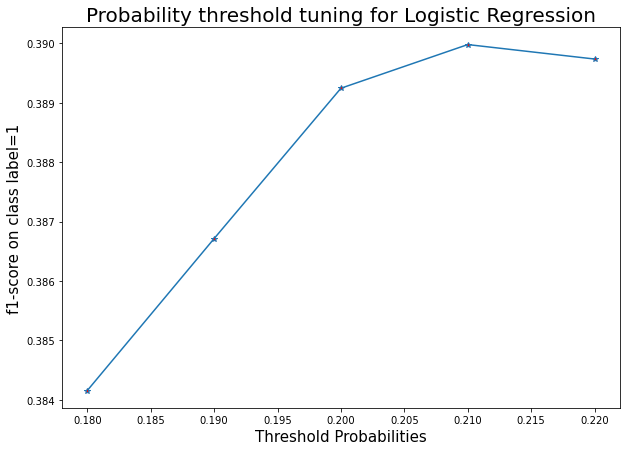

In [30]:
plt.figure(figsize=(10,7))
plt.plot(threshold_probs_2,f1_scores,marker='*',mfc='r')
plt.xlabel('Threshold Probabilities',size=15)
plt.ylabel('f1-score on class label=1',size=15)
plt.title('Probability threshold tuning for Logistic Regression',size=20)
plt.show()

**Best Probability Threshold for Logistic Regression without balancing class weights:** 0.21

In [41]:
y_pred_LR_train=[1 if i[1]>=0.21 else 0 for i in best_LR.predict_proba(X_train)]
y_pred_LR_test=[1 if i[1]>=0.21 else 0 for i in best_LR.predict_proba(X_test)]
print('f1-score on train data: {}'.format(f1_score(y_train,y_pred_LR_train,average=None)))
print('f1-score on test data: {}'.format(f1_score(y_test,y_pred_LR_test,average=None)))

f1-score on train data: [0.91798629 0.3881856 ]
f1-score on test data: [0.91790001 0.38801788]


Train data


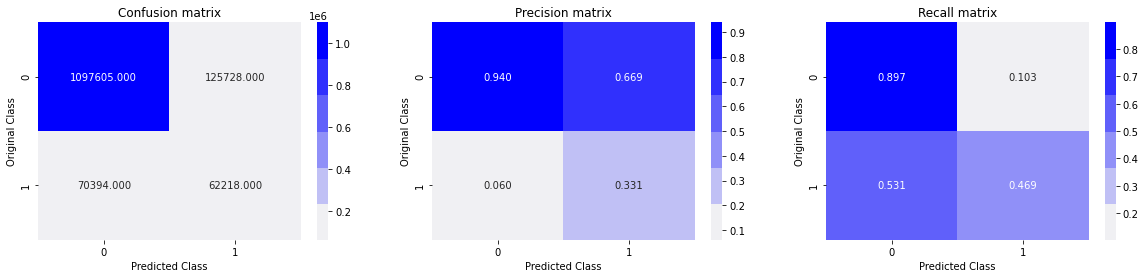

Test data


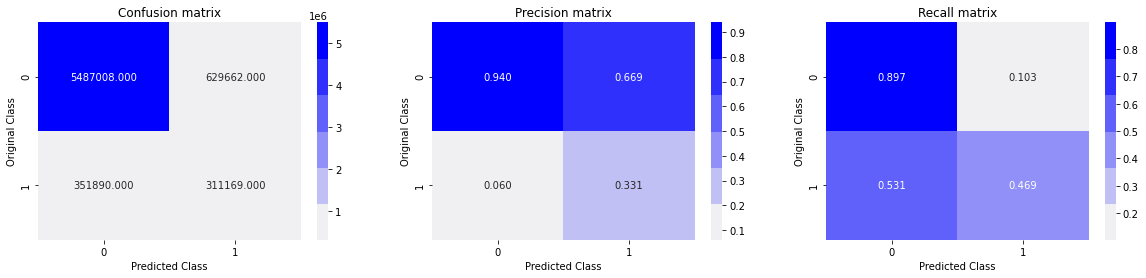

In [42]:
# Confusion, Precision and Recall matrices on train and test data predictions
print('Train data')
plot_confusion_matrix(y_train,y_pred_LR_train)
print('Test data')
plot_confusion_matrix(y_test,y_pred_LR_test)

### ***3.1. Logistic Regression without balancing class weights:***

* ***Optimum probability threshold    :*** 0.21
* ***Test f1-score of '1=will reorder':*** 0.388
* ***Test recall of '1=will reorder'  :*** 0.469
* ***Model did not over-fit or under-fit to train data***

### ***Logistic Regression without balancing class weights Kaggle Submission:***

***Tried with thresholds 0.21 and 0.22***

<img src="Kaggle Submission Screenshots/LR.png">

## ***3.2. Logistic Regression with balanced class weights***

In [33]:
# Lambda is the regularization strength in Logistic Regression and it's hyperparameter
Lambda=[0.0001,0.001,0.01,0.1,0.5,1]
for lamb in Lambda:
    LR=LogisticRegression(C=1/lamb,n_jobs=-1,class_weight='balanced')
    LR.fit(X_train,y_train)
    f1=f1_score(y_cv,LR.predict(X_cv))
    print("f1-score of 1='will reorder' with Lambda={}: {}".format(lamb,f1))

f1-score of 1='will reorder' with Lambda=0.0001: 0.3571273854427307
f1-score of 1='will reorder' with Lambda=0.001: 0.35647752996623006
f1-score of 1='will reorder' with Lambda=0.01: 0.35799965578395204
f1-score of 1='will reorder' with Lambda=0.1: 0.34982604499059994
f1-score of 1='will reorder' with Lambda=0.5: 0.35487502143235206
f1-score of 1='will reorder' with Lambda=1: 0.3595668087541986


***Optimum hyper-parameter observed:*** C=1 i.e., Lambda(regularization strength)=1

In [53]:
best_balanced_LR=LogisticRegression(C=1,n_jobs=-1,class_weight='balanced')
best_balanced_LR.fit(X_train,y_train)

LogisticRegression(C=1, class_weight='balanced', n_jobs=-1)

### *Tuning Probability Threshold*

In [35]:
threshold_probs_1=[0.1,0.2,0.3,0.4,0.5,0.6,0.7]
for threshold in threshold_probs_1:
    y_pred=[]
    for label_prob in best_balanced_LR.predict_proba(X_cv):
        if label_prob[1]>=threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)
    f1=f1_score(y_cv,y_pred)
    print("f1-score of 1='will reorder' with threshold probability={}: {}".format(threshold,f1))

f1-score of 1='will reorder' with threshold probability=0.1: 0.19731770214276903
f1-score of 1='will reorder' with threshold probability=0.2: 0.22146828697551937
f1-score of 1='will reorder' with threshold probability=0.3: 0.2516772483309334
f1-score of 1='will reorder' with threshold probability=0.4: 0.29581003831898994
f1-score of 1='will reorder' with threshold probability=0.5: 0.3595668087541986
f1-score of 1='will reorder' with threshold probability=0.6: 0.40119514149002966
f1-score of 1='will reorder' with threshold probability=0.7: 0.384087715148395


In [36]:
threshold_probs_2=[0.59,0.6,0.61,0.62,0.63,0.64,0.65,0.7]
f1_scores=[]
for threshold in threshold_probs_2:
    y_pred=[]
    for label_prob in best_balanced_LR.predict_proba(X_cv):
        if label_prob[1]>=threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)
    f1=f1_score(y_cv,y_pred)
    f1_scores.append(f1)
    print("f1-score of 1='will reorder' with threshold probability={}: {}".format(threshold,f1))

f1-score of 1='will reorder' with threshold probability=0.59: 0.3989708584930428
f1-score of 1='will reorder' with threshold probability=0.6: 0.40119514149002966
f1-score of 1='will reorder' with threshold probability=0.61: 0.40176123063203656
f1-score of 1='will reorder' with threshold probability=0.62: 0.4022206673472431
f1-score of 1='will reorder' with threshold probability=0.63: 0.40162204854357497
f1-score of 1='will reorder' with threshold probability=0.64: 0.4010358681446343
f1-score of 1='will reorder' with threshold probability=0.65: 0.3995733650829086
f1-score of 1='will reorder' with threshold probability=0.7: 0.384087715148395


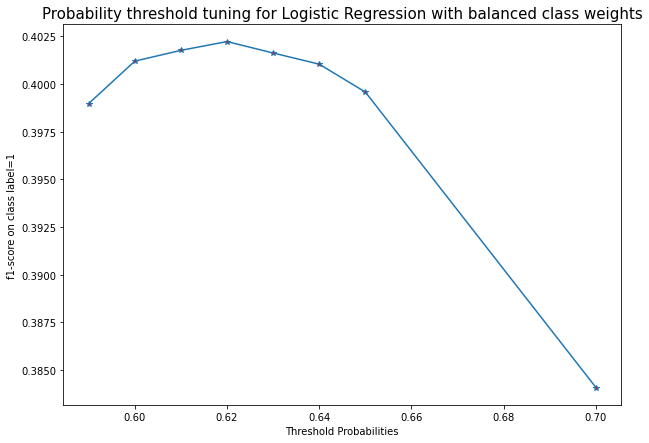

In [37]:
plt.figure(figsize=(10,7))
plt.plot(threshold_probs_2,f1_scores,marker='*',mfc='r')
plt.xlabel('Threshold Probabilities',size=10)
plt.ylabel('f1-score on class label=1',size=10)
plt.title('Probability threshold tuning for Logistic Regression with balanced class weights',size=15)
plt.show()

**Best Probability Threshold for Logistic Regression with balanced class weights:** 0.62

In [44]:
y_pred_balanced_LR_train=[1 if i[1]>=0.62 else 0 for i in best_balanced_LR.predict_proba(X_train)]
y_pred_balanced_LR_test=[1 if i[1]>=0.62 else 0 for i in best_balanced_LR.predict_proba(X_test)]
print('f1-score on train data: {}'.format(f1_score(y_train,y_pred_balanced_LR_train,average=None)))
print('f1-score on test data: {}'.format(f1_score(y_test,y_pred_balanced_LR_test,average=None)))

f1-score on train data: [0.91148417 0.40064419]
f1-score on test data: [0.91141062 0.40034492]


Train data


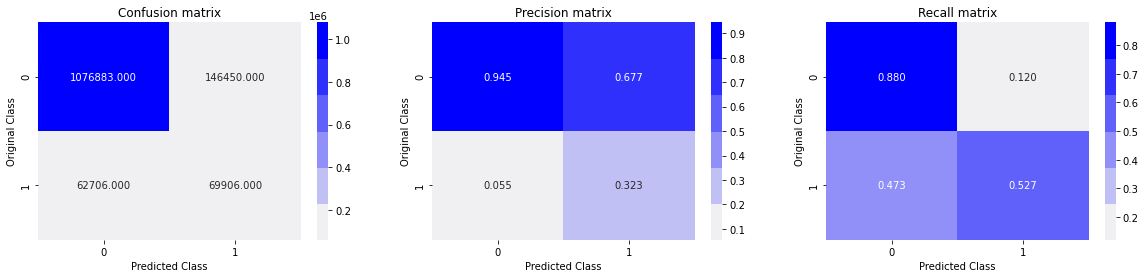

Test data


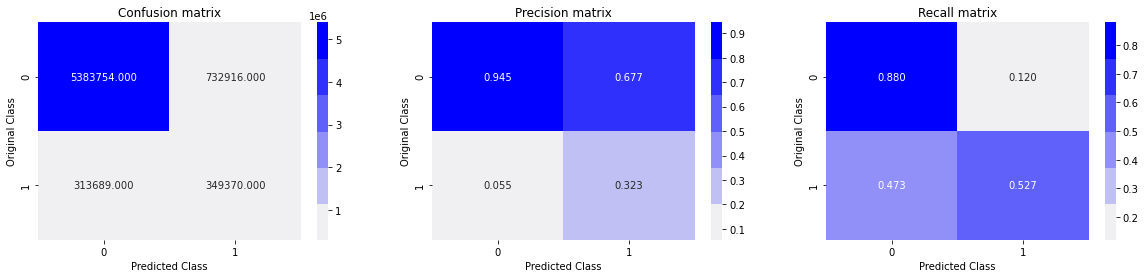

In [45]:
# Confusion, Precision and Recall matrices on train and test data predictions
print('Train data')
plot_confusion_matrix(y_train,y_pred_balanced_LR_train)
print('Test data')
plot_confusion_matrix(y_test,y_pred_balanced_LR_test)

***Also checking with 0.5 as threshold***

In [46]:
y_pred_balanced_LR_train=[1 if i[1]>=0.5 else 0 for i in best_balanced_LR.predict_proba(X_train)]
y_pred_balanced_LR_test=[1 if i[1]>=0.5 else 0 for i in best_balanced_LR.predict_proba(X_test)]
print('f1-score on train data: {}'.format(f1_score(y_train,y_pred_balanced_LR_train,average=None)))
print('f1-score on test data: {}'.format(f1_score(y_test,y_pred_balanced_LR_test,average=None)))

f1-score on train data: [0.84364337 0.35836586]
f1-score on test data: [0.84350988 0.35806669]


Train data


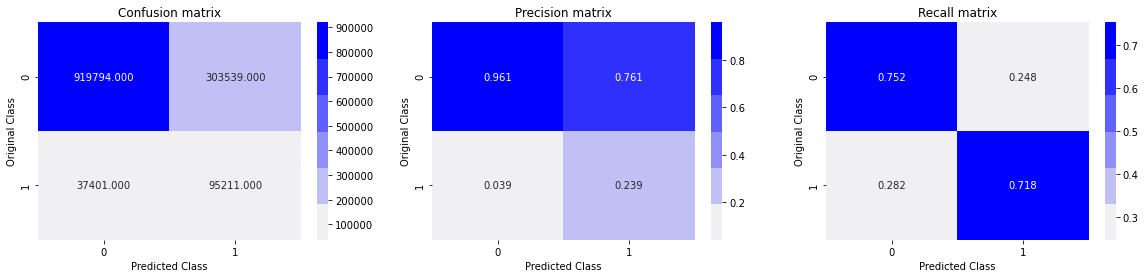

Test data


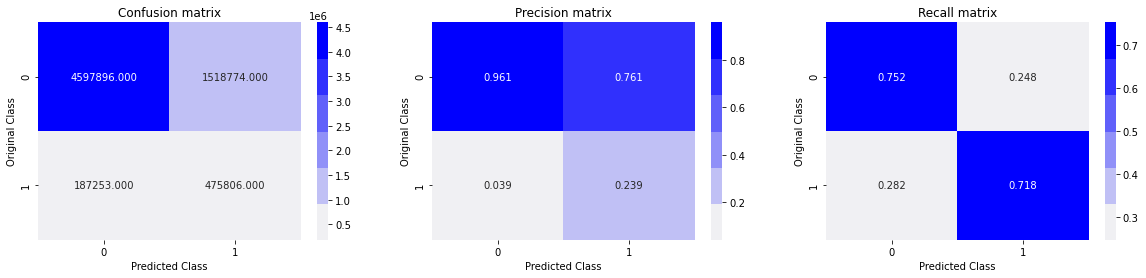

In [47]:
# Confusion, Precision and Recall matrices on train and test data predictions
print('Train data')
plot_confusion_matrix(y_train,y_pred_balanced_LR_train)
print('Test data')
plot_confusion_matrix(y_test,y_pred_balanced_LR_test)

### ***3.2. Logistic Regression with balanced class weights:***

* ***Optimum probability threshold    :*** 0.62
* ***Test f1-score of '1=will reorder':*** 0.4003
* ***Test recall of '1=will reorder'  :*** 0.527
* *Model did not over-fit or under-fit to train data*
* *When tried with threshold=0.5, recall of '1=will reorder' improved to 0.718 but f1 came down to 0.3580 because precision declined*

### ***Logistic Regression with balanced class weights Kaggle Submission:***

<img src="Kaggle Submission Screenshots/balanced_LR.png">

## ***3.3. Random Forest Classifier without balancing class weights***

In [40]:
# Main hyperparameter in RandomForestClassifier are number of base learners(n_estimators)
estimators=[100,250,500,750,1000]
for est in estimators:
    RFC=RandomForestClassifier(n_estimators=est,n_jobs=-1)
    RFC.fit(X_train,y_train)
    f1=f1_score(y_cv,RFC.predict(X_cv))
    print("f1-score of 1='will reorder' with n_estimators={}: {}".format(est,f1))

f1-score of 1='will reorder' with n_estimators=100: 0.28553423890211455
f1-score of 1='will reorder' with n_estimators=250: 0.2854268535198746
f1-score of 1='will reorder' with n_estimators=500: 0.2869223940569079
f1-score of 1='will reorder' with n_estimators=750: 0.2875722205328531
f1-score of 1='will reorder' with n_estimators=1000: 0.2887263037329656


In [30]:
# The next important hyperparameter in RandomForest is Depth of the trees and we want deep trees in RandomForest
# But too deep trees in each base learner results in overfitting to train data. That's what happend when I built model with just n_estimators=1000.
# Depth of the tree can be tuned with max_depth. It is the maximum depth of each learner.
# Depth can also be tuned using min_samples_split

max_depth=[15,12,10,8,5] # Over-fit(too-deep trees) to under-fit(shallow trees)
for md in max_depth:
    RFC=RandomForestClassifier(n_estimators=1000,max_depth=md,n_jobs=-1)
    RFC.fit(X_train,y_train)
    f1_train=f1_score(y_train,RFC.predict(X_train))
    f1_cv=f1_score(y_cv,RFC.predict(X_cv))
    print("f1-score of 1='will reorder' with n_estimators=1000 and max_depth={} on train: {}".format(md,f1_train))
    print("f1-score of 1='will reorder' with n_estimators=1000 and max_depth={} on cv: {}".format(md,f1_cv))
    print('*'*20)

f1-score of 1='will reorder' with n_estimators=1000 and max_depth=15 on train: 0.3742831729981509
f1-score of 1='will reorder' with n_estimators=1000 and max_depth=15 on cv: 0.27553849434847516
********************
f1-score of 1='will reorder' with n_estimators=1000 and max_depth=12 on train: 0.30112035641748014
f1-score of 1='will reorder' with n_estimators=1000 and max_depth=12 on cv: 0.2692536886515863
********************
f1-score of 1='will reorder' with n_estimators=1000 and max_depth=10 on train: 0.2755367482228269
f1-score of 1='will reorder' with n_estimators=1000 and max_depth=10 on cv: 0.26312009193641067
********************
f1-score of 1='will reorder' with n_estimators=1000 and max_depth=8 on train: 0.2607103933717492
f1-score of 1='will reorder' with n_estimators=1000 and max_depth=8 on cv: 0.2586674995795392
********************
f1-score of 1='will reorder' with n_estimators=1000 and max_depth=5 on train: 0.23825730117580565
f1-score of 1='will reorder' with n_estimator

In [25]:
# The next important hyperparameter in RandomForest is Depth of the trees and we want deep trees in RandomForest
# But too deep trees results in overfitting to train data. That's what happend when I built model with just n_estimators=1000.
# Depth of the tree can be tuned with min_samples_split and the default value is 2. Having only 2 nodes in leaf is ofcourse overfit.
# min_samples_split is what control the overfitting to train data. We increase min_samples_split.
# But much higher values of min_samples_split results in shallow trees. We have to tune keeping that in consideration.

min_samples_split=[5,8,10,15]
for mss in min_samples_split:
    RFC=RandomForestClassifier(n_estimators=1000,min_samples_split=mss,n_jobs=-1)
    RFC.fit(X_train,y_train)
    f1_train=f1_score(y_train,RFC.predict(X_train))
    f1_cv=f1_score(y_cv,RFC.predict(X_cv))
    print("f1-score of 1='will reorder' with n_estimators=1000 and min_samples_split={} on train: {}".format(mss,f1_train))
    print("f1-score of 1='will reorder' with n_estimators=1000 and min_samples_split={} on cv: {}".format(mss,f1_cv))
    print('*'*20)

f1-score of 1='will reorder' with n_estimators=1000 and min_samples_split=5 on train: 0.9329218984474635
f1-score of 1='will reorder' with n_estimators=1000 and min_samples_split=5 on cv: 0.28739346258312265
********************
f1-score of 1='will reorder' with n_estimators=1000 and min_samples_split=8 on train: 0.7893808053770844
f1-score of 1='will reorder' with n_estimators=1000 and min_samples_split=8 on cv: 0.28778763547835856
********************
f1-score of 1='will reorder' with n_estimators=1000 and min_samples_split=10 on train: 0.730004824157086
f1-score of 1='will reorder' with n_estimators=1000 and min_samples_split=10 on cv: 0.2877357385498419
********************
f1-score of 1='will reorder' with n_estimators=1000 and min_samples_split=15 on train: 0.6304131689267448
f1-score of 1='will reorder' with n_estimators=1000 and min_samples_split=15 on cv: 0.2854058620608735
********************


***Optimum hyper-parameters observed:*** n_estimators=1000 and max_depth=12

In [25]:
best_RFC=RandomForestClassifier(n_estimators=1000,max_depth=12,n_jobs=-1)
best_RFC.fit(X_train,y_train)

RandomForestClassifier(max_depth=12, n_estimators=1000, n_jobs=-1)

### *Tuning Probability Threshold*

In [32]:
threshold_probs_1=[0.1,0.2,0.3,0.4,0.5]
for threshold in threshold_probs_1:
    y_pred=[]
    for label_prob in best_RFC.predict_proba(X_cv):
        if label_prob[1]>=threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)
    f1=f1_score(y_cv,y_pred)
    print("f1-score of 1='will reorder' with threshold probability={}: {}".format(threshold,f1))

f1-score of 1='will reorder' with threshold probability=0.1: 0.3804427411942484
f1-score of 1='will reorder' with threshold probability=0.2: 0.4412909132524605
f1-score of 1='will reorder' with threshold probability=0.3: 0.42164298866496613
f1-score of 1='will reorder' with threshold probability=0.4: 0.35678381565066297
f1-score of 1='will reorder' with threshold probability=0.5: 0.26918400915397267


In [33]:
threshold_probs_2=[0.21,0.22,0.23,0.24,0.25]
f1_scores=[]
for threshold in threshold_probs_2:
    y_pred=[]
    for label_prob in best_RFC.predict_proba(X_cv):
        if label_prob[1]>=threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)
    f1=f1_score(y_cv,y_pred)
    f1_scores.append(f1)
    print("f1-score of 1='will reorder' with threshold probability={}: {}".format(threshold,f1))

f1-score of 1='will reorder' with threshold probability=0.21: 0.44206637197334564
f1-score of 1='will reorder' with threshold probability=0.22: 0.4422386368290985
f1-score of 1='will reorder' with threshold probability=0.23: 0.44255415035349127
f1-score of 1='will reorder' with threshold probability=0.24: 0.4406430457618758
f1-score of 1='will reorder' with threshold probability=0.25: 0.4388161724101906


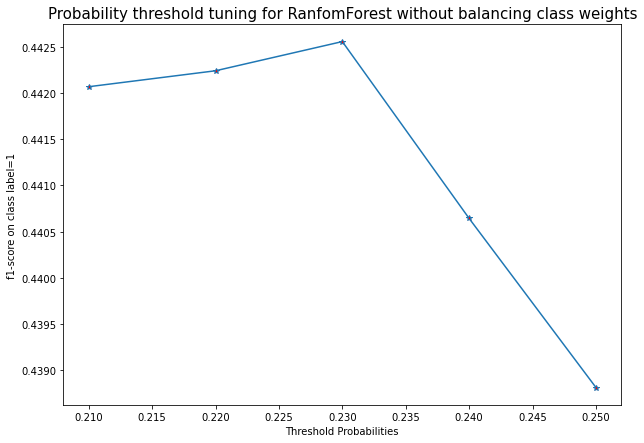

In [34]:
plt.figure(figsize=(10,7))
plt.plot(threshold_probs_2,f1_scores,marker='*',mfc='r')
plt.xlabel('Threshold Probabilities',size=10)
plt.ylabel('f1-score on class label=1',size=10)
plt.title('Probability threshold tuning for RanfomForest without balancing class weights',size=15)
plt.show()

**Best Probability Threshold for Random Forest Classifier without balancing class weights:** 0.23

In [35]:
y_pred_RF_train=[1 if i[1]>=0.23 else 0 for i in best_RFC.predict_proba(X_train)]
y_pred_RF_test=[1 if i[1]>=0.23 else 0 for i in best_RFC.predict_proba(X_test)]
print('f1-score on train data: {}'.format(f1_score(y_train,y_pred_RF_train,average=None)))
print('f1-score on test data: {}'.format(f1_score(y_test,y_pred_RF_test,average=None)))

f1-score on train data: [0.9376387  0.46695865]
f1-score on test data: [0.93421246 0.43840095]


Train data


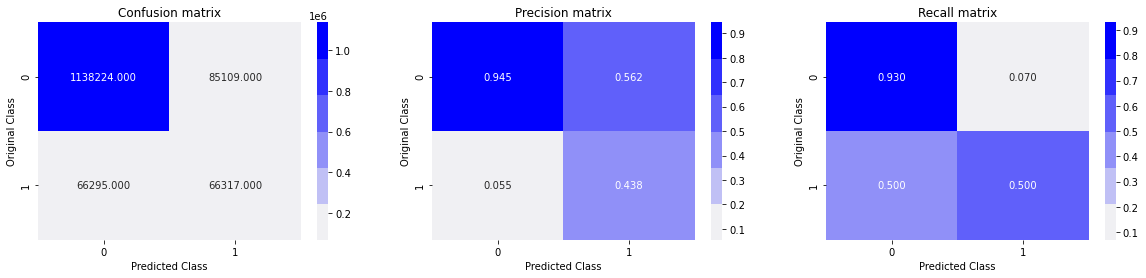

Test data


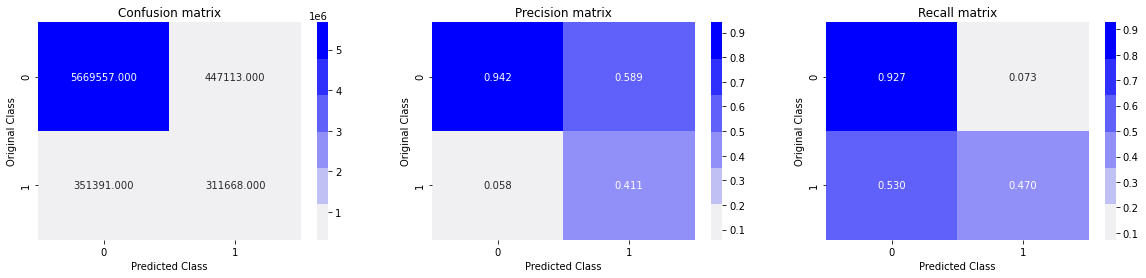

In [37]:
# Confusion, Precision and Recall matrices on test data predictions
print('Train data')
plot_confusion_matrix(y_train,y_pred_RF_train)
print('Test data')
plot_confusion_matrix(y_test,y_pred_RF_test)

### ***3.3. Random Forest Classifier without balancing class weights:***

* ***Optimum probability threshold    :*** 0.23
* ***Test f1-score of '1=will reorder':*** 0.4384
* ***Test recall of '1=will reorder'  :*** 0.47
* *No overfitting on train data observed.*

### ***Random Forest Classifier without balancing class weights Kaggle Submission:***

<img src='Kaggle Submission Screenshots/RFC.png'>

## ***3.4. Random Forest Classifier with balanced class weights***

In [51]:
# Main hyperparameter in RandomForestClassifier are number of base learners(n_estimators)
estimators=[100,250,500,750,1000]
for est in estimators:
    RFC=RandomForestClassifier(n_estimators=est,n_jobs=-1,class_weight='balanced')
    RFC.fit(X_train,y_train)
    f1=f1_score(y_cv,RFC.predict(X_cv))
    print("f1-score of 1='will reorder' with n_estimators={}: {}".format(est,f1))

f1-score of 1='will reorder' with n_estimators=100: 0.24807935427404454
f1-score of 1='will reorder' with n_estimators=250: 0.2473207326578332
f1-score of 1='will reorder' with n_estimators=500: 0.24839942549721267
f1-score of 1='will reorder' with n_estimators=750: 0.24905109489051094
f1-score of 1='will reorder' with n_estimators=1000: 0.24953164156589866


In [38]:
# The next important hyperparameter in RandomForest is Depth of the trees and we want deep trees in RandomForest
# But too deep trees in each base learner results in overfitting to train data. That's what happend when I built model with just n_estimators=1000.
# Depth of the tree can be tuned with max_depth. It is the maximum depth of each learner.
# Depth can also be tuned using min_samples_split

max_depth=[15,12,10,8,5] # Over-fit(too-deep trees) to under-fit(shallow trees)
for md in max_depth:
    RFC=RandomForestClassifier(n_estimators=1000,max_depth=md,n_jobs=-1,class_weight='balanced')
    RFC.fit(X_train,y_train)
    f1_train=f1_score(y_train,RFC.predict(X_train))
    f1_cv=f1_score(y_cv,RFC.predict(X_cv))
    print("f1-score of 1='will reorder' with n_estimators=1000 and max_depth={} on train: {}".format(md,f1_train))
    print("f1-score of 1='will reorder' with n_estimators=1000 and max_depth={} on cv: {}".format(md,f1_cv))
    print('*'*20)

f1-score of 1='will reorder' with n_estimators=1000 and max_depth=15 on train: 0.46266554850551433
f1-score of 1='will reorder' with n_estimators=1000 and max_depth=15 on cv: 0.4051231240512313
********************
f1-score of 1='will reorder' with n_estimators=1000 and max_depth=12 on train: 0.4053715609282987
f1-score of 1='will reorder' with n_estimators=1000 and max_depth=12 on cv: 0.3895614257964576
********************
f1-score of 1='will reorder' with n_estimators=1000 and max_depth=10 on train: 0.388311196349133
f1-score of 1='will reorder' with n_estimators=1000 and max_depth=10 on cv: 0.3828010919941591
********************
f1-score of 1='will reorder' with n_estimators=1000 and max_depth=8 on train: 0.3820573931209607
f1-score of 1='will reorder' with n_estimators=1000 and max_depth=8 on cv: 0.38093958883112367
********************
f1-score of 1='will reorder' with n_estimators=1000 and max_depth=5 on train: 0.3837641086745395
f1-score of 1='will reorder' with n_estimators=1

***Optimum hyper-parameters observed:*** n_estimators=1000 and max_depth=12

In [23]:
best_balanced_RFC=RandomForestClassifier(n_estimators=1000,max_depth=12,n_jobs=-1,class_weight='balanced')
best_balanced_RFC.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=1000,
                       n_jobs=-1)

### *Tuning Probability Threshold*

In [41]:
threshold_probs_1=[0.1,0.2,0.3,0.4,0.5,0.6]
for threshold in threshold_probs_1:
    y_pred=[]
    for label_prob in best_balanced_RFC.predict_proba(X_cv):
        if label_prob[1]>=threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)
    f1=f1_score(y_cv,y_pred)
    print("f1-score of 1='will reorder' with threshold probability={}: {}".format(threshold,f1))

f1-score of 1='will reorder' with threshold probability=0.1: 0.19976290351997084
f1-score of 1='will reorder' with threshold probability=0.2: 0.245975766970326
f1-score of 1='will reorder' with threshold probability=0.3: 0.2907924524611646
f1-score of 1='will reorder' with threshold probability=0.4: 0.34205010354058285
f1-score of 1='will reorder' with threshold probability=0.5: 0.3895999606679887
f1-score of 1='will reorder' with threshold probability=0.6: 0.42528385517871586


In [44]:
threshold_probs_2=[0.66,0.67,0.68,0.69,0.7,0.71,0.72]
f1_scores=[]
for threshold in threshold_probs_2:
    y_pred=[]
    for label_prob in best_balanced_RFC.predict_proba(X_cv):
        if label_prob[1]>=threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)
    f1=f1_score(y_cv,y_pred)
    f1_scores.append(f1)
    print("f1-score of 1='will reorder' with threshold probability={}: {}".format(threshold,f1))

f1-score of 1='will reorder' with threshold probability=0.66: 0.43702721288928187
f1-score of 1='will reorder' with threshold probability=0.67: 0.43798273512039976
f1-score of 1='will reorder' with threshold probability=0.68: 0.4390800721206854
f1-score of 1='will reorder' with threshold probability=0.69: 0.4391786414762038
f1-score of 1='will reorder' with threshold probability=0.7: 0.4389292532516585
f1-score of 1='will reorder' with threshold probability=0.71: 0.43829618958845296
f1-score of 1='will reorder' with threshold probability=0.72: 0.43788012947990307


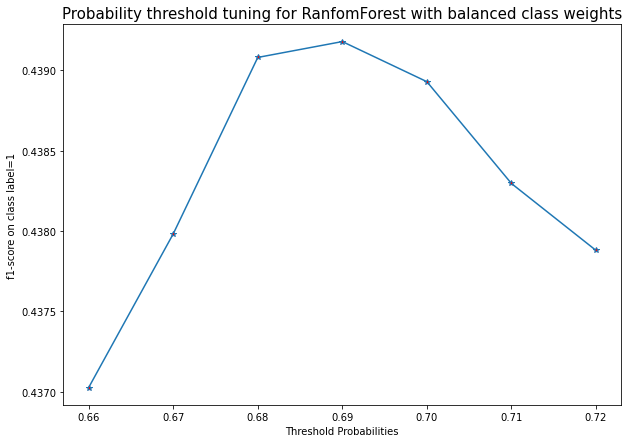

In [45]:
plt.figure(figsize=(10,7))
plt.plot(threshold_probs_2,f1_scores,marker='*',mfc='r')
plt.xlabel('Threshold Probabilities',size=10)
plt.ylabel('f1-score on class label=1',size=10)
plt.title('Probability threshold tuning for RanfomForest with balanced class weights',size=15)
plt.show()

**Best Probability Threshold for Random Forest Classifier with balanced class weights:** 0.69

In [46]:
y_pred_balanced_RF_train=[1 if i[1]>=0.69 else 0 for i in best_balanced_RFC.predict_proba(X_train)]
y_pred_balanced_RF_test=[1 if i[1]>=0.69 else 0 for i in best_balanced_RFC.predict_proba(X_test)]
print('f1-score on train data: {}'.format(f1_score(y_train,y_pred_balanced_RF_train,average=None)))
print('f1-score on test data: {}'.format(f1_score(y_test,y_pred_balanced_RF_test,average=None)))

f1-score on train data: [0.93315526 0.46431005]
f1-score on test data: [0.93003824 0.4371948 ]


Train data


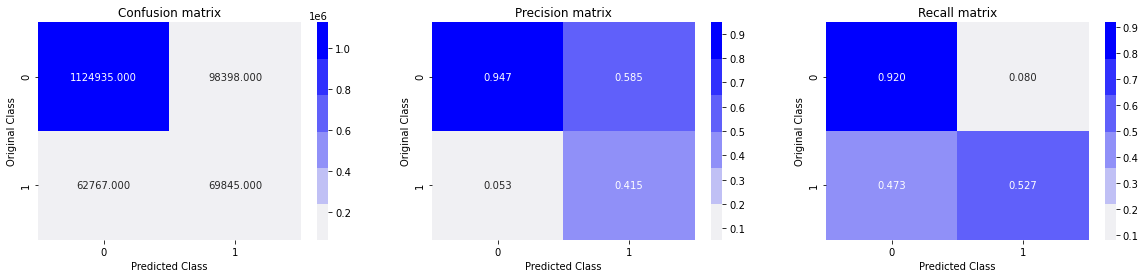

Test data


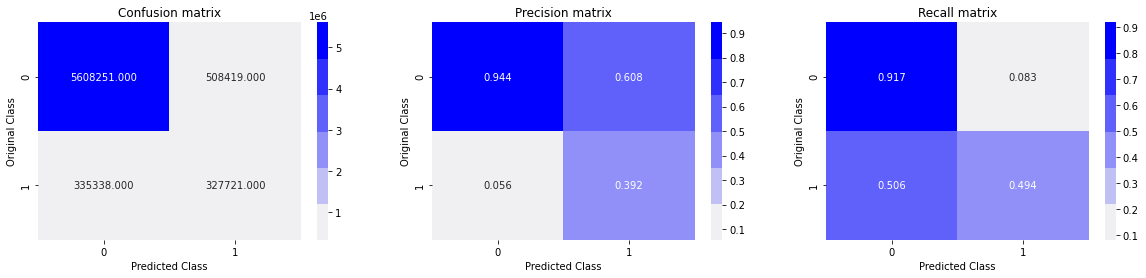

In [48]:
# Confusion, Precision and Recall matrices on test data predictions
print('Train data')
plot_confusion_matrix(y_train,y_pred_balanced_RF_train)
print('Test data')
plot_confusion_matrix(y_test,y_pred_balanced_RF_test)

***Also checking with 0.5 as threshold***

In [49]:
y_pred_balanced_RF_train=[1 if i[1]>=0.5 else 0 for i in best_balanced_RFC.predict_proba(X_train)]
y_pred_balanced_RF_test=[1 if i[1]>=0.5 else 0 for i in best_balanced_RFC.predict_proba(X_test)]
print('f1-score on train data: {}'.format(f1_score(y_train,y_pred_balanced_RF_train,average=None)))
print('f1-score on test data: {}'.format(f1_score(y_test,y_pred_balanced_RF_test,average=None)))

f1-score on train data: [0.86929204 0.40551649]
f1-score on test data: [0.86544448 0.38786818]


Train data


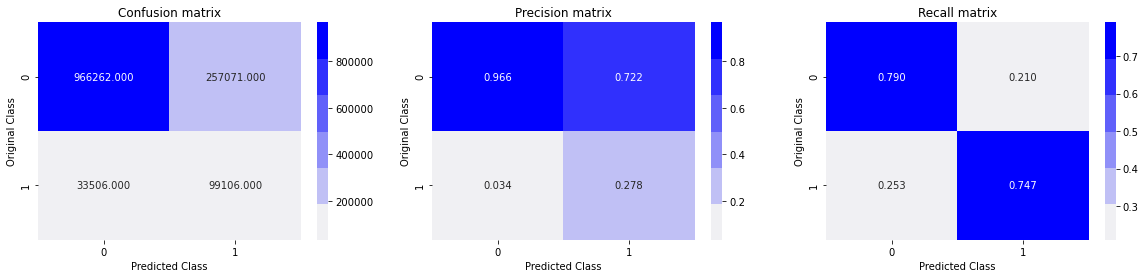

Test data


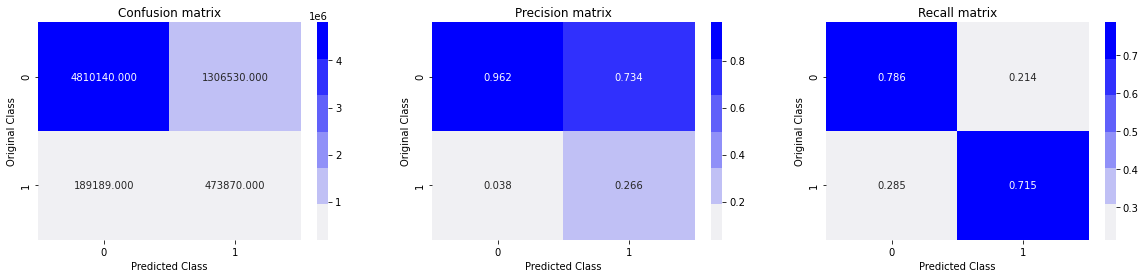

In [51]:
# Confusion, Precision and Recall matrices on test data predictions
print('Train data')
plot_confusion_matrix(y_train,y_pred_balanced_RF_train)
print('Test data')
plot_confusion_matrix(y_test,y_pred_balanced_RF_test)

### ***3.4. Random Forest Classifier with balanced class weights:***

* ***Optimum probability threshold    :*** 0.69
* ***Test f1-score of '1=will reorder':*** 0.4371
* ***Test recall of '1=will reorder'  :*** 0.494
* *When tried with threshold=0.5, recall of '1=will reorder' improved to 0.715 but f1 came down to 0.3878 because precision declined*
* *No overfitting on train data observed.*

### ***Random Forest Classifier with balanced class weights Kaggle Submission:***

<img src='Kaggle Submission Screenshots/balanced RFC.png'>

## ***3.5. XGBClassifier (Gradient Boosting Decision Trees)***

In [31]:
# Main hyperparameter of XGB classifier is number of base learners(n_estimators)
n_estimators=[100,250,500,750,1000,1250]
for est in n_estimators:
    XGB=XGBClassifier(n_estimators=est,n_jobs=-1,eval_metric='error')
    XGB.fit(X_train,y_train)
    f1=f1_score(y_cv,XGB.predict(X_cv))
    print("f1-score of 1='will reorder' with n_estimators={}: {}".format(est,f1))

f1-score of 1='will reorder' with n_estimators=100: 0.2959195468731939
f1-score of 1='will reorder' with n_estimators=250: 0.2995910490281671
f1-score of 1='will reorder' with n_estimators=500: 0.3030952761114026
f1-score of 1='will reorder' with n_estimators=750: 0.30403951154307984
f1-score of 1='will reorder' with n_estimators=1000: 0.3057678003921834
f1-score of 1='will reorder' with n_estimators=1250: 0.30517368975802295


In [52]:
# max_depth: Maximum depth of each tree. In Boosting we need shallow trees, default=6
max_depth=[3,5]
for depth in max_depth:
    XGB=XGBClassifier(n_estimators=1000,max_depth=depth,n_jobs=-1,eval_metric='error')
    XGB.fit(X_train,y_train)
    f1_train=f1_score(y_train,XGB.predict(X_train))
    f1_cv=f1_score(y_cv,XGB.predict(X_cv))
    print("f1-score of 1='will reorder' with n_estimators=1000 and max_depth={} on train: {}".format(depth,f1_train))
    print("f1-score of 1='will reorder' with n_estimators=1000 and max_depth={} on cv: {}".format(depth,f1_cv))

f1-score of 1='will reorder' with n_estimators=1000 and max_depth=3 on train: 0.31708583294877707
f1-score of 1='will reorder' with n_estimators=1000 and max_depth=3 on cv: 0.2996934848240418
f1-score of 1='will reorder' with n_estimators=1000 and max_depth=5 on train: 0.3840600146652377
f1-score of 1='will reorder' with n_estimators=1000 and max_depth=5 on cv: 0.30309930999931683


In [53]:
# max_depth: Maximum depth of each tree. In Boosting we need shallow trees, default=6
max_depth=[6,7]
for depth in max_depth:
    XGB=XGBClassifier(n_estimators=1000,max_depth=depth,n_jobs=-1,eval_metric='error')
    XGB.fit(X_train,y_train)
    f1_train=f1_score(y_train,XGB.predict(X_train))
    f1_cv=f1_score(y_cv,XGB.predict(X_cv))
    print("f1-score of 1='will reorder' with n_estimators=1000 and max_depth={} on train: {}".format(depth,f1_train))
    print("f1-score of 1='will reorder' with n_estimators=1000 and max_depth={} on cv: {}".format(depth,f1_cv))

f1-score of 1='will reorder' with n_estimators=1000 and max_depth=6 on train: 0.44899957639473403
f1-score of 1='will reorder' with n_estimators=1000 and max_depth=6 on cv: 0.3057678003921834
f1-score of 1='will reorder' with n_estimators=1000 and max_depth=7 on train: 0.5316312207007973
f1-score of 1='will reorder' with n_estimators=1000 and max_depth=7 on cv: 0.3058607648756909


***Optimum hyper-parameters observed:*** n_estimators=1000 and max_depth=3

In [37]:
best_XGB=XGBClassifier(n_estimators=1000,max_depth=3,n_jobs=-1,eval_metric='error')
best_XGB.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

### *Tuning Probability Threshold*

In [55]:
threshold_probs_1=[0.1,0.2,0.3,0.4,0.5]
for threshold in threshold_probs_1:
    y_pred=[]
    for label_prob in best_XGB.predict_proba(X_cv):
        if label_prob[1]>=threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)
    f1=f1_score(y_cv,y_pred)
    print("f1-score of 1='will reorder' with threshold probability={}: {}".format(threshold,f1))

f1-score of 1='will reorder' with threshold probability=0.1: 0.38160494019194574
f1-score of 1='will reorder' with threshold probability=0.2: 0.4439728779507785
f1-score of 1='will reorder' with threshold probability=0.3: 0.42969673755558146
f1-score of 1='will reorder' with threshold probability=0.4: 0.37573637332368254
f1-score of 1='will reorder' with threshold probability=0.5: 0.2996934848240418


In [56]:
threshold_probs_2=[0.19,0.2,0.21,0.22,0.23,0.24]
f1_scores=[]
for threshold in threshold_probs_2:
    y_pred=[]
    for label_prob in best_XGB.predict_proba(X_cv):
        if label_prob[1]>=threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)
    f1=f1_score(y_cv,y_pred)
    f1_scores.append(f1)
    print("f1-score of 1='will reorder' with threshold probability={}: {}".format(threshold,f1))

f1-score of 1='will reorder' with threshold probability=0.19: 0.441886084377459
f1-score of 1='will reorder' with threshold probability=0.2: 0.4439728779507785
f1-score of 1='will reorder' with threshold probability=0.21: 0.44492906006204813
f1-score of 1='will reorder' with threshold probability=0.22: 0.44568745808182425
f1-score of 1='will reorder' with threshold probability=0.23: 0.44554510237963474
f1-score of 1='will reorder' with threshold probability=0.24: 0.44481476733752084


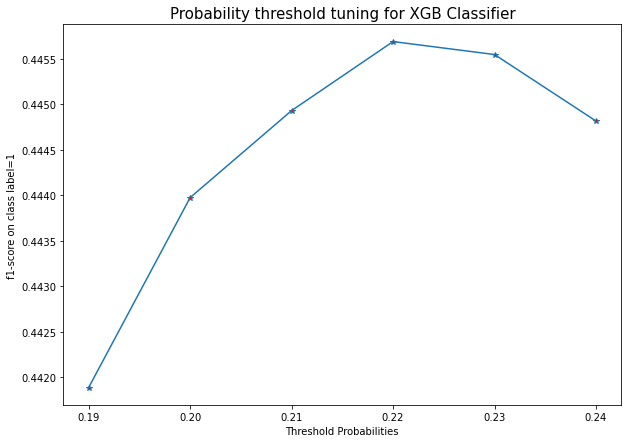

In [57]:
plt.figure(figsize=(10,7))
plt.plot(threshold_probs_2,f1_scores,marker='*',mfc='r')
plt.xlabel('Threshold Probabilities',size=10)
plt.ylabel('f1-score on class label=1',size=10)
plt.title('Probability threshold tuning for XGB Classifier',size=15)
plt.show()

**Best Probability Threshold for XGBClassifier(Gradient Boosting):** 0.22

In [58]:
y_pred_XGB_train=[1 if i[1]>=0.22 else 0 for i in best_XGB.predict_proba(X_train)]
y_pred_XGB_test=[1 if i[1]>=0.22 else 0 for i in best_XGB.predict_proba(X_test)]
print('f1-score on train data: {}'.format(f1_score(y_train,y_pred_XGB_train,average=None)))
print('f1-score on test data: {}'.format(f1_score(y_test,y_pred_XGB_test,average=None)))

f1-score on train data: [0.93324497 0.4613728 ]
f1-score on test data: [0.93104236 0.44286822]


Train data


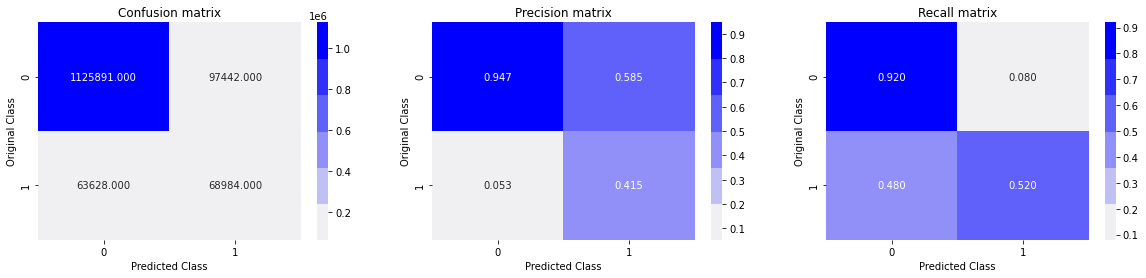

Test data


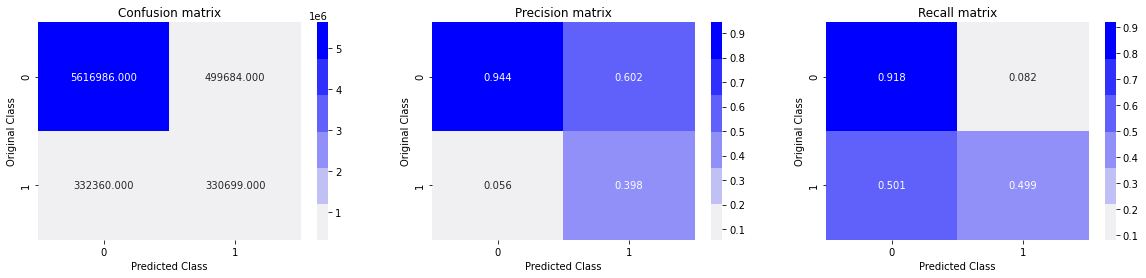

In [59]:
# Confusion, Precision and Recall matrices on train and test data predictions
print('Train data')
plot_confusion_matrix(y_train,y_pred_XGB_train)
print('Test data')
plot_confusion_matrix(y_test,y_pred_XGB_test)

### ***3.5. XGB Classifier(Gradient Boosting Decision Trees):***

* ***Optimum probability threshold    :*** 0.22
* ***Test f1-score of '1=will reorder':*** 0.4428
* ***Test recall of '1=will reorder'  :*** 0.499
* *No overfitting observed*

### ***XGB Classifier Kaggle Submission:***

<img src='Kaggle Submission Screenshots/XGB.png'>

## ***3.6. Decision tree classifier without balancing class weights***

In [28]:
# Main hyperparameter of Decision tree classifier is depth of tree
max_depth=[10,20,30,40,50,60]
for depth in max_depth:
    DTC=DecisionTreeClassifier(max_depth=depth)
    DTC.fit(X_train,y_train)
    f1_train=f1_score(y_train,DTC.predict(X_train))
    f1_cv=f1_score(y_cv,DTC.predict(X_cv))
    print("f1-score of 1='will reorder' with max_depth={} on train data: {}".format(depth,f1_train))
    print("f1-score of 1='will reorder' with max_depth={} on cv data: {}".format(depth,f1_cv))
    print('*'*25)

f1-score of 1='will reorder' with max_depth=10 on train data: 0.2899916014259956
f1-score of 1='will reorder' with max_depth=10 on cv data: 0.2705021803347869
*************************
f1-score of 1='will reorder' with max_depth=20 on train data: 0.621204001868194
f1-score of 1='will reorder' with max_depth=20 on cv data: 0.2902957181865716
*************************
f1-score of 1='will reorder' with max_depth=30 on train data: 0.9232382904334198
f1-score of 1='will reorder' with max_depth=30 on cv data: 0.2889766562677691
*************************
f1-score of 1='will reorder' with max_depth=40 on train data: 0.9924671577188853
f1-score of 1='will reorder' with max_depth=40 on cv data: 0.28321226564070173
*************************
f1-score of 1='will reorder' with max_depth=50 on train data: 0.9993360244463726
f1-score of 1='will reorder' with max_depth=50 on cv data: 0.28143225861651006
*************************
f1-score of 1='will reorder' with max_depth=60 on train data: 1.0
f1-score

In [30]:
# Main hyperparameter of Decision tree classifier is depth of tree
max_depth=[8,9,10,11,12,13,14]
for depth in max_depth:
    DTC=DecisionTreeClassifier(max_depth=depth)
    DTC.fit(X_train,y_train)
    f1_train=f1_score(y_train,DTC.predict(X_train))
    f1_cv=f1_score(y_cv,DTC.predict(X_cv))
    print("f1-score of 1='will reorder' with max_depth={} on train data: {}".format(depth,f1_train))
    print("f1-score of 1='will reorder' with max_depth={} on cv data: {}".format(depth,f1_cv))
    print('*'*25)

f1-score of 1='will reorder' with max_depth=8 on train data: 0.27239099684546325
f1-score of 1='will reorder' with max_depth=8 on cv data: 0.26734076734076734
*************************
f1-score of 1='will reorder' with max_depth=9 on train data: 0.27143855624652774
f1-score of 1='will reorder' with max_depth=9 on cv data: 0.25999379489749647
*************************
f1-score of 1='will reorder' with max_depth=10 on train data: 0.2899982380924414
f1-score of 1='will reorder' with max_depth=10 on cv data: 0.27042742256922464
*************************
f1-score of 1='will reorder' with max_depth=11 on train data: 0.30364977130589
f1-score of 1='will reorder' with max_depth=11 on cv data: 0.2728268724212686
*************************
f1-score of 1='will reorder' with max_depth=12 on train data: 0.3122419137860443
f1-score of 1='will reorder' with max_depth=12 on cv data: 0.26734222139204744
*************************
f1-score of 1='will reorder' with max_depth=13 on train data: 0.34103217219

***Optimum hyper-parameters observed:*** max_depth=11

In [ ]:
best_DTC=DecisionTreeClassifier(max_depth=11)
best_DTC.fit(X_train,y_train)

### *Tuning Probability Threshold*

In [32]:
threshold_probs_1=[0.1,0.2,0.3,0.4,0.5]
for threshold in threshold_probs_1:
    y_pred=[]
    for label_prob in best_DTC.predict_proba(X_cv):
        if label_prob[1]>=threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)
    f1=f1_score(y_cv,y_pred)
    print("f1-score of 1='will reorder' with threshold probability={}: {}".format(threshold,f1))

f1-score of 1='will reorder' with threshold probability=0.1: 0.37596843729617074
f1-score of 1='will reorder' with threshold probability=0.2: 0.4294236615490288
f1-score of 1='will reorder' with threshold probability=0.3: 0.40539007579794095
f1-score of 1='will reorder' with threshold probability=0.4: 0.34704333449000835
f1-score of 1='will reorder' with threshold probability=0.5: 0.27413692897826336


In [33]:
threshold_probs_2=[0.19,0.2,0.21,0.22,0.23,0.24]
f1_scores=[]
for threshold in threshold_probs_2:
    y_pred=[]
    for label_prob in best_DTC.predict_proba(X_cv):
        if label_prob[1]>=threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)
    f1=f1_score(y_cv,y_pred)
    f1_scores.append(f1)
    print("f1-score of 1='will reorder' with threshold probability={}: {}".format(threshold,f1))

f1-score of 1='will reorder' with threshold probability=0.19: 0.4272711950109557
f1-score of 1='will reorder' with threshold probability=0.2: 0.4294236615490288
f1-score of 1='will reorder' with threshold probability=0.21: 0.42952197056674674
f1-score of 1='will reorder' with threshold probability=0.22: 0.42943439123365895
f1-score of 1='will reorder' with threshold probability=0.23: 0.42772769661175014
f1-score of 1='will reorder' with threshold probability=0.24: 0.4277324165592322


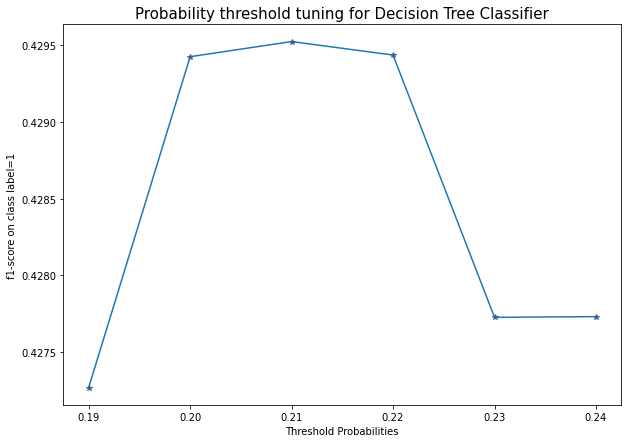

In [34]:
plt.figure(figsize=(10,7))
plt.plot(threshold_probs_2,f1_scores,marker='*',mfc='r')
plt.xlabel('Threshold Probabilities',size=10)
plt.ylabel('f1-score on class label=1',size=10)
plt.title('Probability threshold tuning for Decision Tree Classifier',size=15)
plt.show()

**Best Probability Threshold for Decision Tree Classifier:** 0.21

In [35]:
y_pred_DTC_train=[1 if i[1]>=0.21 else 0 for i in best_DTC.predict_proba(X_train)]
y_pred_DTC_test=[1 if i[1]>=0.21 else 0 for i in best_DTC.predict_proba(X_test)]
print('f1-score on train data: {}'.format(f1_score(y_train,y_pred_DTC_train,average=None)))
print('f1-score on test data: {}'.format(f1_score(y_test,y_pred_DTC_test,average=None)))

f1-score on train data: [0.929587   0.44779993]
f1-score on test data: [0.92715312 0.42839126]


Train data


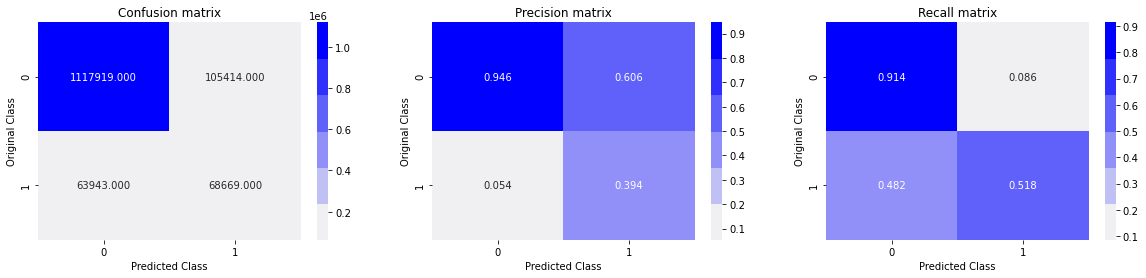

Test data


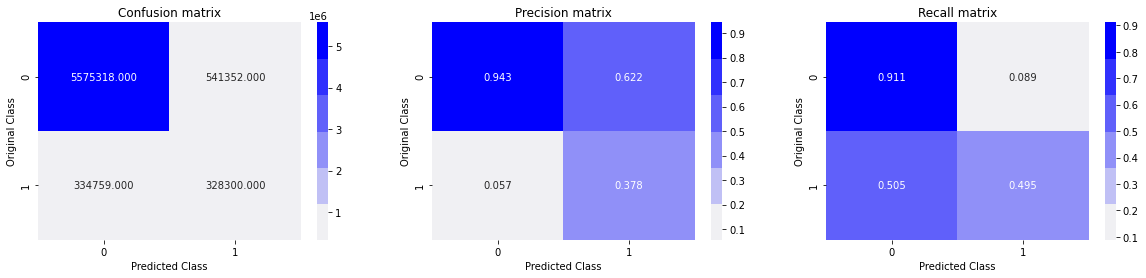

In [36]:
# Confusion, Precision and Recall matrices on train and test data predictions
print('Train data')
plot_confusion_matrix(y_train,y_pred_DTC_train)
print('Test data')
plot_confusion_matrix(y_test,y_pred_DTC_test)

### ***3.6. Decision Tree Classifier without balancing class weights:***

* ***Optimum probability threshold    :*** 0.21
* ***Test f1-score of '1=will reorder':*** 0.4283
* ***Test recall of '1=will reorder'  :*** 0.495
* *No overfitting observed*

### ***Decision Tree Classifier without balancing class weights Kaggle Submission:***

<img src='Kaggle Submission Screenshots/DTC.png'>

## ***3.7. Decision tree classifier with balanced class weights***

In [37]:
# Main hyperparameter of Decision tree classifier is depth of tree
max_depth=[10,20,30,40,50,60]
for depth in max_depth:
    DTC=DecisionTreeClassifier(max_depth=depth,class_weight='balanced')
    DTC.fit(X_train,y_train)
    f1_train=f1_score(y_train,DTC.predict(X_train))
    f1_cv=f1_score(y_cv,DTC.predict(X_cv))
    print("f1-score of 1='will reorder' with max_depth={} on train data: {}".format(depth,f1_train))
    print("f1-score of 1='will reorder' with max_depth={} on cv data: {}".format(depth,f1_cv))
    print('*'*25)

f1-score of 1='will reorder' with max_depth=10 on train data: 0.3798774453031229
f1-score of 1='will reorder' with max_depth=10 on cv data: 0.3712130485341821
*************************
f1-score of 1='will reorder' with max_depth=20 on train data: 0.5057495390491242
f1-score of 1='will reorder' with max_depth=20 on cv data: 0.3444190072947181
*************************
f1-score of 1='will reorder' with max_depth=30 on train data: 0.7695230190576112
f1-score of 1='will reorder' with max_depth=30 on cv data: 0.33889831887832217
*************************
f1-score of 1='will reorder' with max_depth=40 on train data: 0.9265477476343782
f1-score of 1='will reorder' with max_depth=40 on cv data: 0.30532033426183847
*************************
f1-score of 1='will reorder' with max_depth=50 on train data: 0.9810009987792697
f1-score of 1='will reorder' with max_depth=50 on cv data: 0.27850796138322564
*************************
f1-score of 1='will reorder' with max_depth=60 on train data: 0.99616518

In [38]:
# Main hyperparameter of Decision tree classifier is depth of tree
max_depth=[7,8,9,10,11,12]
for depth in max_depth:
    DTC=DecisionTreeClassifier(max_depth=depth,class_weight='balanced')
    DTC.fit(X_train,y_train)
    f1_train=f1_score(y_train,DTC.predict(X_train))
    f1_cv=f1_score(y_cv,DTC.predict(X_cv))
    print("f1-score of 1='will reorder' with max_depth={} on train data: {}".format(depth,f1_train))
    print("f1-score of 1='will reorder' with max_depth={} on cv data: {}".format(depth,f1_cv))
    print('*'*25)

f1-score of 1='will reorder' with max_depth=7 on train data: 0.365816238929639
f1-score of 1='will reorder' with max_depth=7 on cv data: 0.3658534781740603
*************************
f1-score of 1='will reorder' with max_depth=8 on train data: 0.3675705609805623
f1-score of 1='will reorder' with max_depth=8 on cv data: 0.3663150746610176
*************************
f1-score of 1='will reorder' with max_depth=9 on train data: 0.37668775221895334
f1-score of 1='will reorder' with max_depth=9 on cv data: 0.37178820506545945
*************************
f1-score of 1='will reorder' with max_depth=10 on train data: 0.3798774453031229
f1-score of 1='will reorder' with max_depth=10 on cv data: 0.3712628905413263
*************************
f1-score of 1='will reorder' with max_depth=11 on train data: 0.3809382188072928
f1-score of 1='will reorder' with max_depth=11 on cv data: 0.3668381450209766
*************************
f1-score of 1='will reorder' with max_depth=12 on train data: 0.3866341879117191

***Optimum hyper-parameters observed:*** max_depth=9

In [39]:
best_balanced_DTC=DecisionTreeClassifier(max_depth=9,class_weight='balanced')
best_balanced_DTC.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=9)

### *Tuning Probability Threshold*

In [41]:
threshold_probs_1=[0.3,0.4,0.5,0.6,0.7,0.8]
for threshold in threshold_probs_1:
    y_pred=[]
    for label_prob in best_balanced_DTC.predict_proba(X_cv):
        if label_prob[1]>=threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)
    f1=f1_score(y_cv,y_pred)
    print("f1-score of 1='will reorder' with threshold probability={}: {}".format(threshold,f1))

f1-score of 1='will reorder' with threshold probability=0.3: 0.2861767813351169
f1-score of 1='will reorder' with threshold probability=0.4: 0.32066629547141795
f1-score of 1='will reorder' with threshold probability=0.5: 0.37178820506545945
f1-score of 1='will reorder' with threshold probability=0.6: 0.4076986045803271
f1-score of 1='will reorder' with threshold probability=0.7: 0.4325210757756129
f1-score of 1='will reorder' with threshold probability=0.8: 0.41429030784071474


In [43]:
threshold_probs_2=[0.68,0.69,0.7,0.71,0.72,0.73,0.74]
f1_scores=[]
for threshold in threshold_probs_2:
    y_pred=[]
    for label_prob in best_balanced_DTC.predict_proba(X_cv):
        if label_prob[1]>=threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)
    f1=f1_score(y_cv,y_pred)
    f1_scores.append(f1)
    print("f1-score of 1='will reorder' with threshold probability={}: {}".format(threshold,f1))

f1-score of 1='will reorder' with threshold probability=0.68: 0.43198365659852955
f1-score of 1='will reorder' with threshold probability=0.69: 0.4327031244329934
f1-score of 1='will reorder' with threshold probability=0.7: 0.4325210757756129
f1-score of 1='will reorder' with threshold probability=0.71: 0.4330241415320351
f1-score of 1='will reorder' with threshold probability=0.72: 0.43350812794965915
f1-score of 1='will reorder' with threshold probability=0.73: 0.4335594275889147
f1-score of 1='will reorder' with threshold probability=0.74: 0.4332682156365602


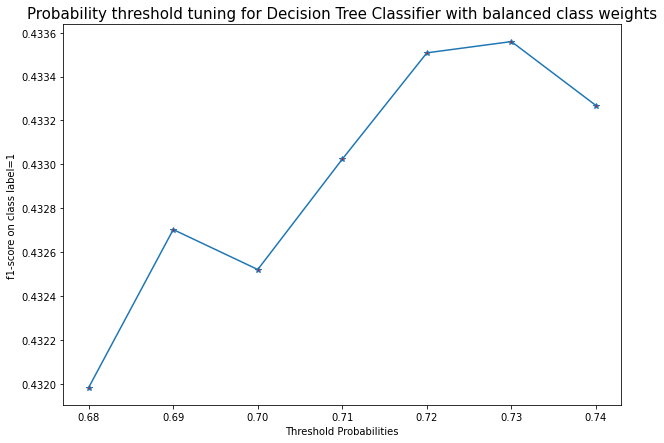

In [44]:
plt.figure(figsize=(10,7))
plt.plot(threshold_probs_2,f1_scores,marker='*',mfc='r')
plt.xlabel('Threshold Probabilities',size=10)
plt.ylabel('f1-score on class label=1',size=10)
plt.title('Probability threshold tuning for Decision Tree Classifier with balanced class weights',size=15)
plt.show()

**Best Probability Threshold for Decision Tree Classifier with balanced class weights:** 0.73

In [45]:
y_pred_balanced_DTC_train=[1 if i[1]>=0.73 else 0 for i in best_balanced_DTC.predict_proba(X_train)]
y_pred_balanced_DTC_test=[1 if i[1]>=0.73 else 0 for i in best_balanced_DTC.predict_proba(X_test)]
print('f1-score on train data: {}'.format(f1_score(y_train,y_pred_balanced_DTC_train,average=None)))
print('f1-score on test data: {}'.format(f1_score(y_test,y_pred_balanced_DTC_test,average=None)))

f1-score on train data: [0.93077925 0.43536662]
f1-score on test data: [0.93028739 0.43106046]


Train data


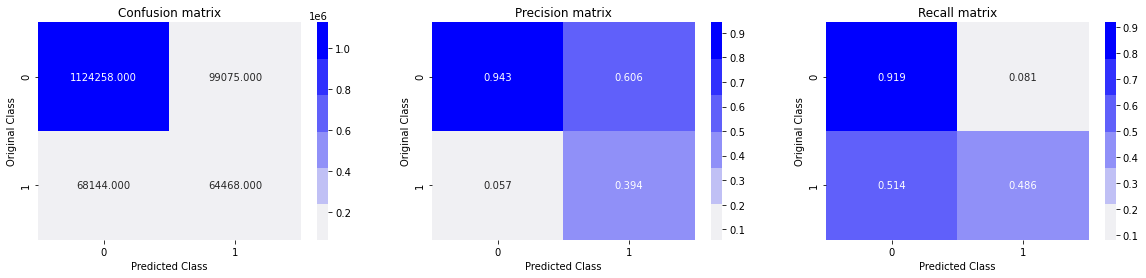

Test data


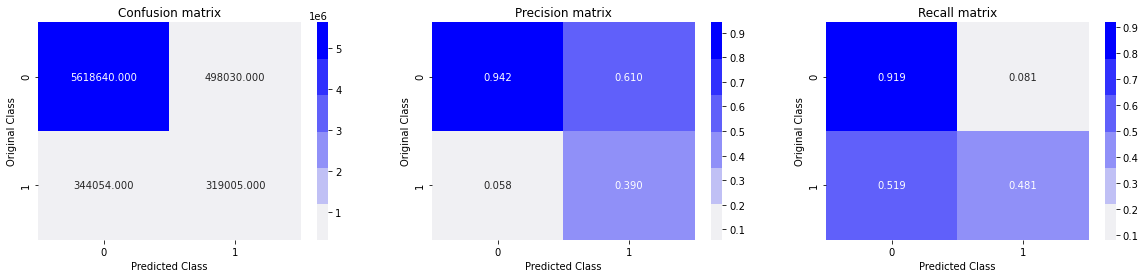

In [46]:
# Confusion, Precision and Recall matrices on train and test data predictions
print('Train data')
plot_confusion_matrix(y_train,y_pred_balanced_DTC_train)
print('Test data')
plot_confusion_matrix(y_test,y_pred_balanced_DTC_test)

***Also checking with 0.5 as threshold***

In [47]:
y_pred_balanced_DTC_train=[1 if i[1]>=0.5 else 0 for i in best_balanced_DTC.predict_proba(X_train)]
y_pred_balanced_DTC_test=[1 if i[1]>=0.5 else 0 for i in best_balanced_DTC.predict_proba(X_test)]
print('f1-score on train data: {}'.format(f1_score(y_train,y_pred_balanced_DTC_train,average=None)))
print('f1-score on test data: {}'.format(f1_score(y_test,y_pred_balanced_DTC_test,average=None)))

f1-score on train data: [0.85103183 0.37668775]
f1-score on test data: [0.84985167 0.37104451]


Train data


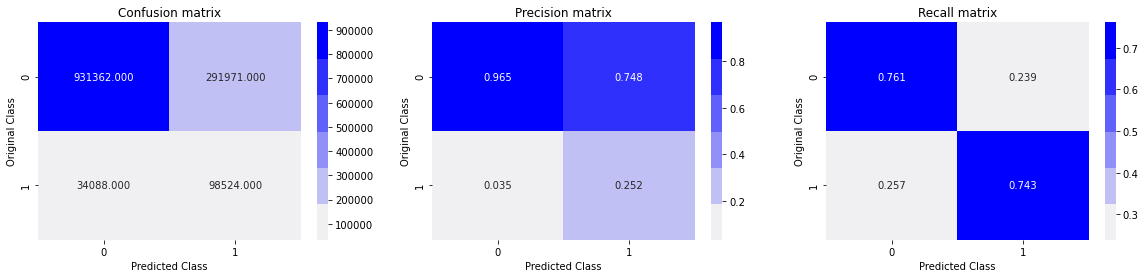

Test data


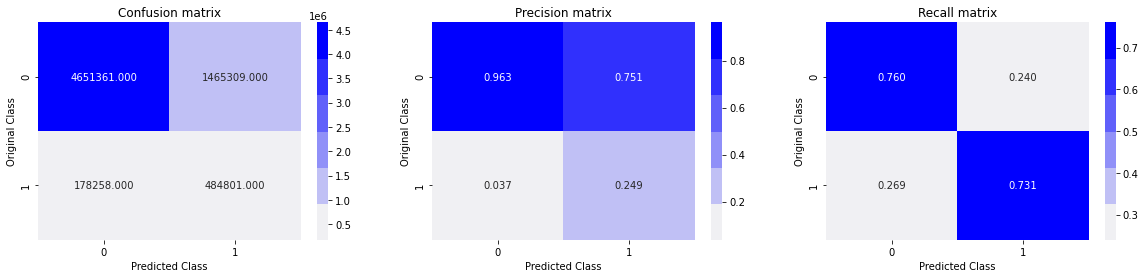

In [48]:
# Confusion, Precision and Recall matrices on train and test data predictions
print('Train data')
plot_confusion_matrix(y_train,y_pred_balanced_DTC_train)
print('Test data')
plot_confusion_matrix(y_test,y_pred_balanced_DTC_test)

### ***3.7. Decision Tree Classifier with balanced class weights:***

* ***Optimum probability threshold    :*** 0.73
* ***Test f1-score of '1=will reorder':*** 0.4310
* ***Test recall of '1=will reorder'  :*** 0.481
* *When tried with threshold=0.5, recall of '1=will reorder' improved to 0.731 but f1 came down to 0.3710 because precision declined*
* *No overfitting observed*

### ***Decision Tree Classifier with balanced class weights Kaggle Submission:***

<img src='Kaggle Submission Screenshots/balanced DTC.png'>

# **4. Important features by models**

### ***4.1. XGB Classifier (Gradient Boosting)***

In [27]:
important_features=best_XGB.get_booster().get_score(importance_type='gain')
keys = list(important_features.keys())
values = list(important_features.values())
XGB_imp_features=pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False).reset_index()

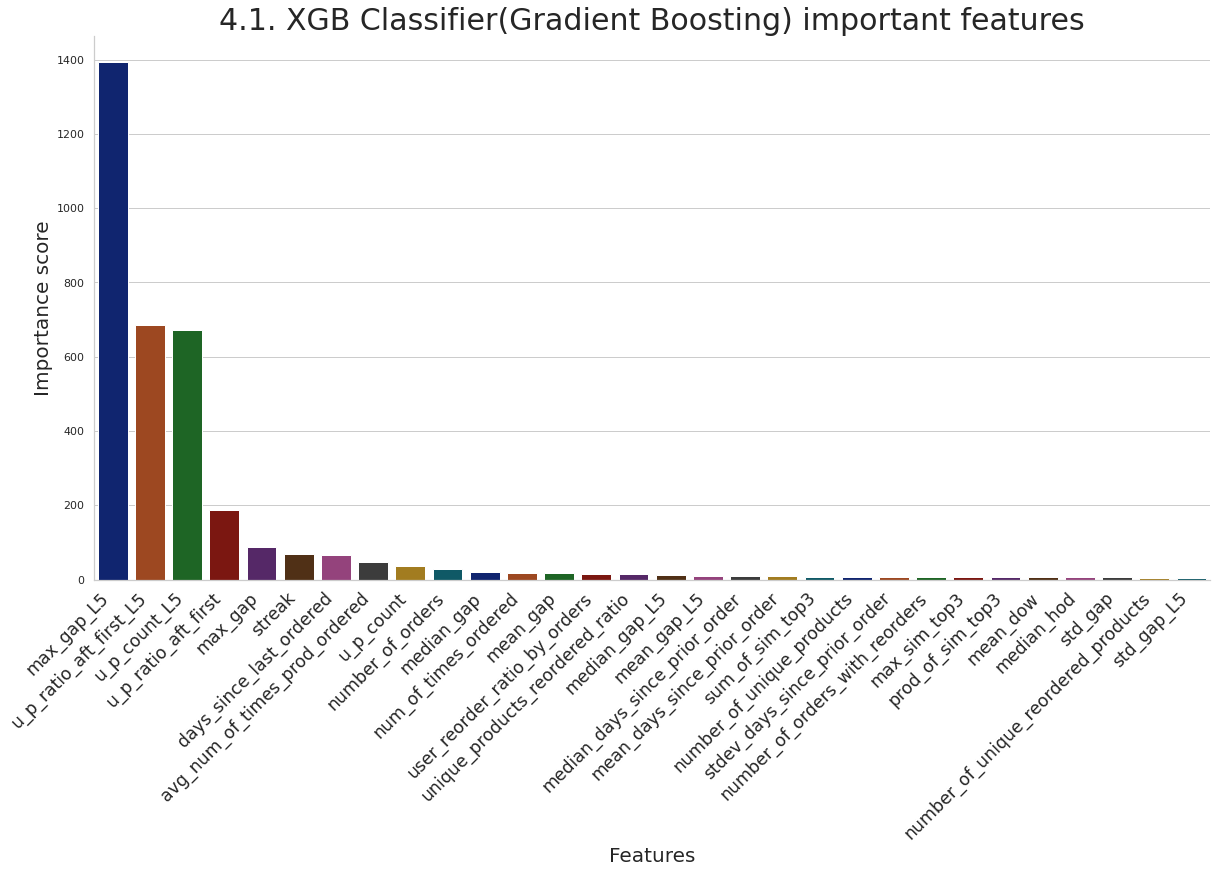

In [28]:
plt.figure(figsize=(20,10))
sns.set(style="whitegrid")
plot=sns.barplot(x='index',y='score',data=XGB_imp_features,palette='dark')
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.xlabel('Features',size=20)
plt.ylabel('Importance score',size=20)
plt.title('4.1. XGB Classifier(Gradient Boosting) important features',size=30)
sns.despine()
plt.show()

### ***4.2. Random Forest Classifier(Bagging) without balancing class weights***

In [41]:
RFC_imp_features=pd.DataFrame(X_train.columns,columns=['feature'])
RFC_imp_features['score']=best_RFC.feature_importances_
RFC_imp_features=RFC_imp_features.sort_values(by = "score", ascending=False).reset_index()

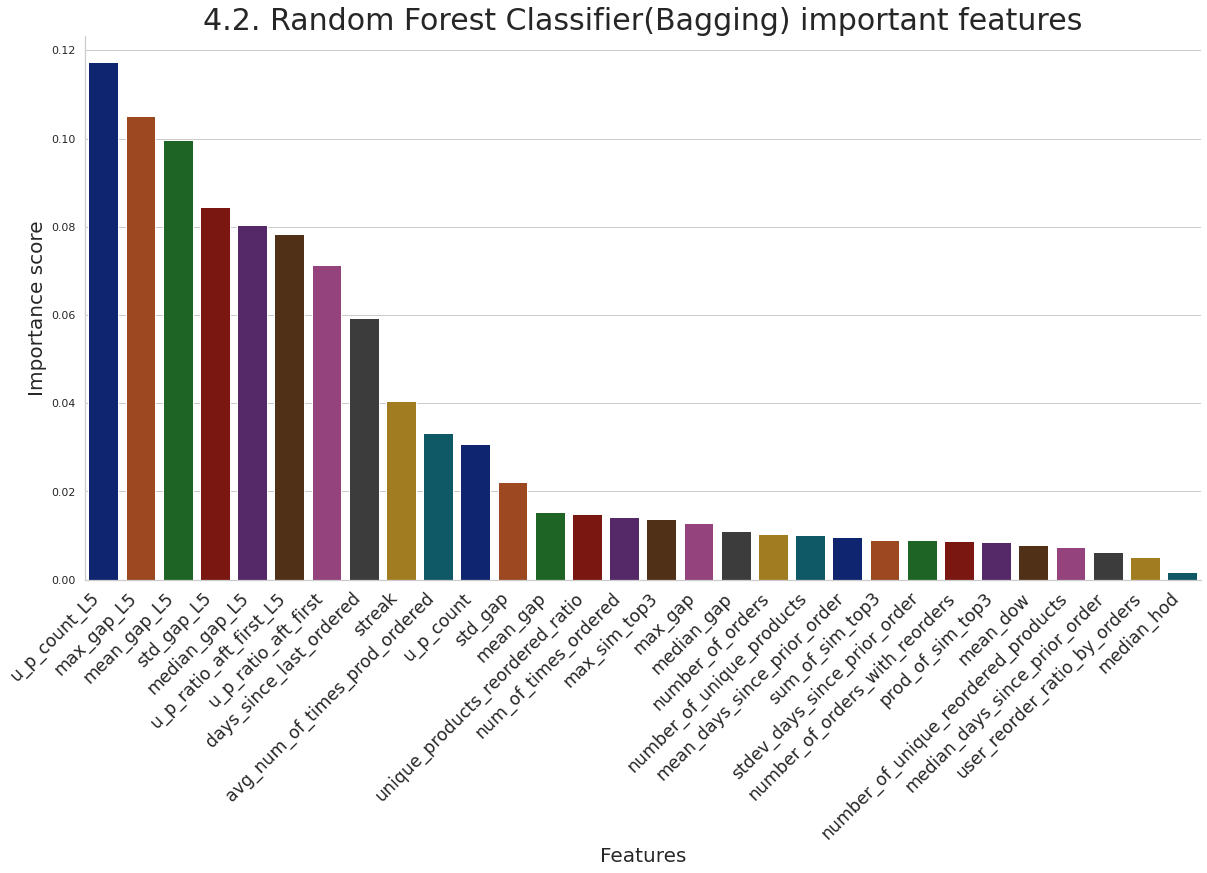

In [48]:
plt.figure(figsize=(20,10))
sns.set(style="whitegrid")
plot=sns.barplot(x='feature',y='score',data=RFC_imp_features,palette='dark')
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.xlabel('Features',size=20)
plt.ylabel('Importance score',size=20)
plt.title('4.2. Random Forest Classifier(Bagging) important features',size=30)
sns.despine()
plt.show()

### ***4.3. Random Forest Classifier(Bagging) with balanced class weights***

In [24]:
balanced_RFC_imp_features=pd.DataFrame(X_train.columns,columns=['feature'])
balanced_RFC_imp_features['score']=best_balanced_RFC.feature_importances_
balanced_RFC_imp_features=balanced_RFC_imp_features.sort_values(by = "score", ascending=False).reset_index()

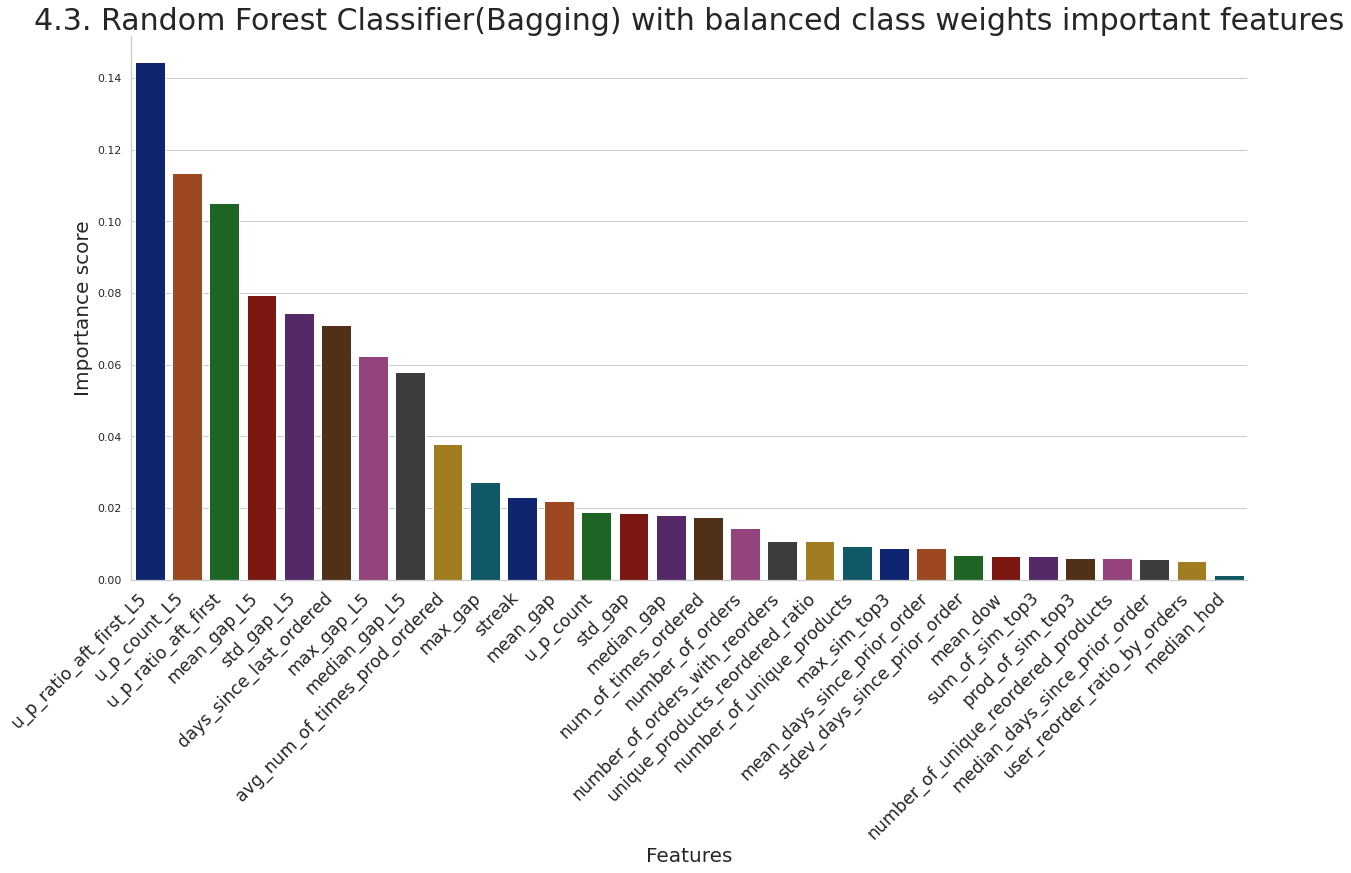

In [25]:
plt.figure(figsize=(20,10))
sns.set(style="whitegrid")
plot=sns.barplot(x='feature',y='score',data=balanced_RFC_imp_features,palette='dark')
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.xlabel('Features',size=20)
plt.ylabel('Importance score',size=20)
plt.title('4.3. Random Forest Classifier(Bagging) with balanced class weights important features',size=30)
sns.despine()
plt.show()

In [1]:
from tabulate import tabulate

data=[['Logistic Regression without balancing class weights','C=(1/0.0001)',0.21,0.388],['Logistic Regression with balanced class weights','C=1',0.62,0.4003],['Logistic Regression with balanced class weights','C=1',0.5,0.358],['Random Forest without balancing class weights','n_est=1000 and max_depth=12',0.23,0.438],['Random Forest with balanced class weights','n_est=1000 and max_depth=12',0.69,0.437],['Random Forest with balanced class weights','n_est=1000 and max_depth=12',0.5,0.387],['XGB Classifier(Boosting)','n_est=1000 and max_depth=3',0.22,0.442],['Decision Tree without balancing class weights','max_depth=11',0.21,0.4283],['Decision Tree with balanced class weights','max_depth=9',0.73,0.4310]]
table=tabulate(data,headers=['Model','hyper-parameter','Probability Threshold','f1-score'],tablefmt='orgtbl')

print(table)

| Model                                               | hyper-parameter             |   Probability Threshold |   f1-score |
|-----------------------------------------------------+-----------------------------+-------------------------+------------|
| Logistic Regression without balancing class weights | C=(1/0.0001)                |                    0.21 |     0.388  |
| Logistic Regression with balanced class weights     | C=1                         |                    0.62 |     0.4003 |
| Logistic Regression with balanced class weights     | C=1                         |                    0.5  |     0.358  |
| Random Forest without balancing class weights       | n_est=1000 and max_depth=12 |                    0.23 |     0.438  |
| Random Forest with balanced class weights           | n_est=1000 and max_depth=12 |                    0.69 |     0.437  |
| Random Forest with balanced class weights           | n_est=1000 and max_depth=12 |                    0.5  |     0.387  |


## ***Kaggle Standings:***
<img src='Kaggle Submission Screenshots/Kaggle Standings.png'>

## ***Summary:***
* *Model performance is evaluated based on f1-score of '1=will reorder'*


* **XGB Classifier(Boosting)** achieved the highest f1-score of 0.442.


* **Random Forest(Bagging) without balancing class weights** achieved the second best and its precision is higher than XGB Classifier.


* **Random Forest(Bagging) with balanced class weights with Threshold probability=0.69** achieved the third best and the same with **Threshold probability=0.5** achieved Recall>0.7 but failed in precision.


* **Logistic Regression models** worked well in achieving good recall than non-linear models but failed in precision.


* *Coming to Kaggle scores upon submission, XGB achieved highest public score whereas Random Forest with balanced classweights achieved highest private score. Difference between both is too small but Random Forest results are with much higher probability threshold than XGB Classifier*


* Considering mean f1-score(both classes), every model succeeded in predicting '0=will not reorder'.


* Classifiers with balanced class weights gave f1-scores with high probability thresholds.